This notebook, the first of a series of two (*01_BEM* and *02_LCA*), focuses on the building energy simulations carried out as part of the doctoral dissertation entitled *Glazing Beyond Energy Efficiency*. As such, it should be read in conjunction with the chapters that present the conceptual and methodological framework (Ch. 4) and discuss the results (Ch. 5).

# Setup

First, import modules and codes from modules to run this notebook:

In [1]:
import glob as gb
from IPython.display import display

import datetime

import pandas as pd
import numpy as np

import math

import pathlib
from pathlib import Path

import sqlite3

import os

from importlib import reload

import tqdm

import multiprocessing
import multiprocess as mp

import shlex
import subprocess
from itertools import product

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Defining a few global parameters:

In [2]:
# To find all the pathnames matching a specified pattern, here .sql files:
gb.glob('**/*.sql', recursive=True)

['EnergyPlus_osm\\OS\\Office_BXL\\run\\eplusout.sql',
 'EnergyPlus_osm\\OS\\Office_BXL_smartglass\\run\\eplusout.sql',
 'EnergyPlus_osm\\OS\\Office_BXL_VAV\\run\\eplusout.sql',
 'EnergyPlus_osm\\OS\\Office_BXL_VRF\\run\\eplusout.sql',
 'EnergyPlus_osm\\_ref_Python_and_BEM\\eplusout.sql',
 'outputs\\energyplus\\eplusout.sql',
 'outputs\\energyplus\\a_a_2126_dg_init\\eplusout.sql',
 'outputs\\energyplus\\a_b_2126_dg0\\eplusout.sql',
 'outputs\\energyplus\\a_c_2126_sg1\\eplusout.sql',
 'outputs\\energyplus\\a_d_2126_sg2\\eplusout.sql',
 'outputs\\energyplus\\a_e_2126_dg1\\eplusout.sql',
 'outputs\\energyplus\\a_f_2126_dg2\\eplusout.sql',
 'outputs\\energyplus\\a_g_2126_dg3\\eplusout.sql',
 'outputs\\energyplus\\a_h_2126_dg4\\eplusout.sql',
 'outputs\\energyplus\\a_i_2126_dg5\\eplusout.sql',
 'outputs\\energyplus\\a_j_2126_dg6\\eplusout.sql',
 'outputs\\energyplus\\a_k_2126_tg1\\eplusout.sql',
 'outputs\\energyplus\\a_l_2126_tg2\\eplusout.sql',
 'outputs\\energyplus\\a_m_2126_tg3\\eplusout

In [3]:
# Defining the directory with datasets:
ROOT_DIR = Path('./files').absolute()
ROOT_DIR

WindowsPath('C:/Users/souvi/Documents/These/80_Calculations/05_LCA/files')

In [4]:
# Defining the size of figures:
mpl.rcParams['figure.figsize'] = (16, 10)
pd.options.display.max_rows = 200

In [5]:
# Defining the path where to save figures:
path_img = os.path.abspath(os.path.join('outputs', 'IMG'))
if not os.path.exists(path_img):
    os.makedirs(path_img)
print(f'Images will be saved in {path_img}')

Images will be saved in C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\IMG


In [6]:
# Defining seaborn main parameters:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("paper", font_scale=1.2,
                rc={"axes.titlesize": 8, "lines.linewidth": 1,
                    "legend.fontsize": 8, "legend.title_fontsize": 8})

In [7]:
# A function used to define the thickness of x and y axis:
def style_ax(ax):
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.tick_params(width=0.5)
        ax.set_xlabel(None)
    return ax

## Class EnergyPlus SQL

Defining a class to work with the output data resulting from the EnergyPlus simulations:

In [8]:
class EPLusSQL():

    def __init__(self, sql_path=None):
        abs_sql_path = os.path.abspath(sql_path)
        self.sql_uri = '{}?mode=ro'.format(pathlib.Path(abs_sql_path).as_uri())

    def get_annual_energy_by_fuel_and_enduse(self):
        """
        Queries SQL file and returns the ABUPS' End Uses table

        Parameters
        ----------
        None

        Returns
        -------
        df_end_use: pd.DataFrame
            Annual End Use table
            index = 'EndUse'
            columns = ['FuelType','Units']
        """

        # RowName = '#{end_use}'
        # ColumnName='#{fuel_type}'
        annual_end_use_query = """SELECT RowName, ColumnName, Units, Value
            FROM TabularDataWithStrings
            WHERE ReportName='AnnualBuildingUtilityPerformanceSummary'
            AND ReportForString='Entire Facility'
            AND TableName='End Uses'
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_end_use = pd.read_sql(annual_end_use_query, con=con)

        # Convert Value to Float
        df_end_use['Value'] = pd.to_numeric(df_end_use['Value'])

        df_end_use = df_end_use.set_index(['RowName',
                                           'ColumnName',
                                           'Units'])['Value'].unstack([1, 2])
        df_end_use.index.name = 'EndUse'
        df_end_use.columns.names = ['FuelType', 'Units']

        end_use_order = ['Heating', 'Cooling',
                         'Interior Lighting', 'Exterior Lighting',
                         'Interior Equipment', 'Exterior Equipment',
                         'Fans', 'Pumps', 'Heat Rejection', 'Humidification',
                         'Heat Recovery', 'Water Systems',
                         'Refrigeration', 'Generators']
        col_order = [
            'Electricity', 'Natural Gas', 'Gasoline', 'Diesel', 'Coal',
            'Fuel Oil No 1', 'Fuel Oil No 2', 'Propane', 'Other Fuel 1',
            'Other Fuel 2', 'District Cooling', 'District Heating',
            'Water']
        df_end_use = df_end_use[col_order].loc[end_use_order]

        # Filter out columns with ALL zeroes
        df_end_use = df_end_use.loc[:, (df_end_use > 0).any(axis=0)]

        return df_end_use

    def get_unmet_hours_table(self):
        """
        Queries 'SystemSummary' and returns all unmet hours

        Parameters
        ----------
        None

        Returns
        -------
        df_unmet: pd.DataFrame
            A DataFrame where


        """

        query = """SELECT RowName, ColumnName, Units, Value FROM TabularDataWithStrings
    WHERE ReportName='SystemSummary'
    AND ReportForString='Entire Facility'
    AND TableName='Time Setpoint Not Met'
    """
        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df_unmet = pd.read_sql(query, con=con)

        # Convert Value to Float
        df_unmet['Value'] = pd.to_numeric(df_unmet['Value'])

        df_unmet = df_unmet.pivot(index='RowName',
                                  columns='ColumnName',
                                  values='Value')

        df_unmet.columns.names = ['Time Setpoint Not Met (hr)']

        # Move 'Facility' as last row (Should always be in the index...)
        if 'Facility' in df_unmet.index:
            df_unmet = df_unmet.loc[[x for x
                                     in df_unmet.index
                                     if x != 'Facility'] + ['Facility']]

        return df_unmet

    def get_reporting_vars(self):
        """
        Queries 'ReportingDataDictionary' and returns a DataFrame

        Parameters
        -----------
        None

        Returns
        ---------
        df_vars: pd.DataFrame
            A DataFrame where each row is a reporting variable
        """

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            query = '''
        SELECT KeyValue, Name, TimestepType, ReportingFrequency, Units, Type
            FROM ReportDataDictionary
            '''
            df_vars = pd.read_sql(query, con=con)

        return df_vars

    def get_hourly_variables(self, variables_list):
        """
        Queries Hourly variables which names are in variables_list

        eg: variables_list=['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']
        """

        query = '''
        SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
            ReportingFrequency, KeyValue, Name, Units,
            Value
        FROM ReportVariableWithTime
        '''

        cond = []

        cond.append(
            ("UPPER(Name) IN ({})".format(', '.join(
                map(repr, [name.upper() for name in variables_list]))))
        )

        cond.append('ReportingFrequency = "Hourly"')

        query += '  WHERE {}'.format('\n    AND '.join(cond))

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df = pd.read_sql(query, con=con)

        df_pivot = pd.pivot_table(df, values='Value',
                                  columns=['ReportingFrequency', 'KeyValue',
                                           'Name', 'Units'],
                                  index=['EnvironmentPeriodIndex',
                                         'Month', 'Day', 'Hour', 'Minute'])

        df_pivot = df_pivot.loc[3]  # Get the annual environment period index

        # We know it's hourly, so recreate a clear index
        (month, day, hour, minute) = df_pivot.index[0]
        start = datetime.datetime(2005, month, day)
        df_pivot.index = pd.date_range(
            start=start, periods=df_pivot.index.size, freq='H')
        df_pivot = df_pivot['Hourly']

        return df_pivot

    def get_timestep_variables(self, variables_list=None):
        """
        Queries 'Zone Timestep' variables which names are in variables_list (if supplied, otherwise all)

        eg: variables_list=['Zone Thermal Comfort CEN 15251 Adaptive Model Temperature']
        """

        query = '''
        SELECT EnvironmentPeriodIndex, Month, Day, Hour, Minute,
            ReportingFrequency, KeyValue, Name, Units,
            Value
        FROM ReportVariableWithTime
        '''

        cond = []

        if variables_list:
            cond.append(
                ("UPPER(Name) IN ({})".format(', '.join(
                    map(repr, [name.upper() for name in variables_list]))))
            )

        cond.append('ReportingFrequency = "Zone Timestep"')

        query += '  WHERE {}'.format('\n    AND '.join(cond))

        with sqlite3.connect(self.sql_uri, uri=True) as con:
            df = pd.read_sql(query, con=con)

        df_pivot = pd.pivot_table(df, values='Value',
                                  columns=['ReportingFrequency', 'KeyValue',
                                           'Name', 'Units'],
                                  index=['EnvironmentPeriodIndex',
                                         'Month', 'Day', 'Hour', 'Minute'])

        df_pivot = df_pivot.loc[3]  # Get the annual environment period index

        # We know it's Zone Timestep, with 15min timestep, so recreate a clear index
        (month, day, hour, minute) = df_pivot.index[0]
        start = datetime.datetime(2005, month, day)

        df_pivot.index = pd.date_range(
            start=start, periods=df_pivot.index.size, freq='15Min')
        df_pivot = df_pivot['Zone Timestep']

        return df_pivot

# List of Scenarios with their Parameters

Importing from the "lca_scenarios" Excel file the scenarios that define the parameters for the BEM and LCA (i.e., the type of glazing, the use of shading devices or not, etc.):

In [9]:
lca_scenarios = pd.ExcelFile(ROOT_DIR / 'lca_scenarios.xlsx')

Defining a series of dataframes for each calculation batch, which corresponds to a specific configuration with different glazing units:

In [10]:
print("lca_scenarios, sheet names = \n {}\n".format(lca_scenarios.sheet_names))

lca_scenarios, sheet names = 
 ['Scenarios', 'Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Step7', 'Step8', 'Step9', 'Step10', 'Step11', 'Step12', 'Step13', 'Step14', 'Step15', 'Step16']



In [11]:
# Creating the dataframes:
df_step1 = lca_scenarios.parse('Step1').set_index('name')
df_step2 = lca_scenarios.parse('Step2').set_index('name')
df_step3 = lca_scenarios.parse('Step3').set_index('name')
df_step4 = lca_scenarios.parse('Step4').set_index('name')
df_step5 = lca_scenarios.parse('Step5').set_index('name')
df_step6 = lca_scenarios.parse('Step6').set_index('name')
df_step7 = lca_scenarios.parse('Step7').set_index('name')
df_step8 = lca_scenarios.parse('Step8').set_index('name')
df_step9 = lca_scenarios.parse('Step9').set_index('name')
df_step10 = lca_scenarios.parse('Step10').set_index('name')
df_step11 = lca_scenarios.parse('Step11').set_index('name')
df_step12 = lca_scenarios.parse('Step12').set_index('name')
df_step13 = lca_scenarios.parse('Step13').set_index('name')
df_step14 = lca_scenarios.parse('Step14').set_index('name')
df_step15 = lca_scenarios.parse('Step15').set_index('name')
df_step16 = lca_scenarios.parse('Step16').set_index('name')

In [12]:
# Naming the dataframes:
df_step1.name = "df_step1"
df_step2.name = "df_step2"
df_step3.name = "df_step3"
df_step4.name = "df_step4"
df_step5.name = "df_step5"
df_step6.name = "df_step6"
df_step7.name = "df_step7"
df_step8.name = "df_step8"
df_step9.name = "df_step9"
df_step10.name = "df_step10"
df_step11.name = "df_step11"
df_step12.name = "df_step12"
df_step13.name = "df_step13"
df_step14.name = "df_step14"
df_step15.name = "df_step15"
df_step16.name = "df_step16"

# Building Energy Simulation with EnergyPlus

Inspired by the notebooks on Data Driven Building posted on GitHub by Clayton Miller:
https://github.com/buds-lab/python-for-building-analysts

## Setup for the Energy Simulation

First, defining the basic settings to use EnergyPlus:

In [13]:
# Importing the Eppy module to help running the energy simulations:
from eppy import modeleditor
from eppy.modeleditor import IDF

# Localisation of the Energy+ app:
iddfile = "C:\EnergyPlusV9-5-0\Energy+.idd"
IDF.setiddname(iddfile)

Then, defining the paths in the study folder where data are saved:

In [14]:
# Main path:
ROOT_DIR_EPlus = ROOT_DIR / 'EnergyPlus'

In [15]:
# Weather data for Brussels:
epwfile = str(ROOT_DIR_EPlus / "BEL_Brussels.064510_IWEC.epw")

Defining the path to the weather file integrating climate change scenario in Brussels.

Weather data from: Ramon, Delphine, Karen Allacker, Hendrik Wouters, Sam Vanden Broucke, and Nicole P.M. Van Lipzig. ‘Typical Downscaled Year (TDY) for Building Energy Simulations (.Epw Format) in Future Climate (2069-2098 - RCP 8.5), Uccle, Belgium’. Zenodo, 20 May 2021. https://doi.org/10.5281/ZENODO.4776320.

In [16]:
# 2069-2098 - IPCC RCP 8.5 (see steps 14-16):
epwfile_cc = str(ROOT_DIR_EPlus / "TDY_Uccle_Future_2069-2098.epw")

Defining the paths to the idf files (i.e., the EnergyPlus files with the building modelling):

In [17]:
# IDF file, initial configuration:
idfname_init = str(ROOT_DIR_EPlus / "BEM_init.idf")

# IDF file, HVAC changed, optimised VAV system:
idfname_vav = str(ROOT_DIR_EPlus / "BEM_VAV.idf")

# IDF file, HVAC changed, VRF system:
idfname_vrf = str(ROOT_DIR_EPlus / "BEM_VRF.idf")

# IDF file for smart glass modeling, initial configuration:
idfname_smartglass = str(ROOT_DIR_EPlus / "BEM_SmartGlass.idf")

In [18]:
# Directory where outputs are saved:
OUT_DIR_EPlus = Path('./outputs/energyplus').absolute()
OUT_DIR_EPlus

WindowsPath('C:/Users/souvi/Documents/These/80_Calculations/05_LCA/outputs/energyplus')

To conduct the scenario and sensitivity analyses according to the different parameters, the initial idf file is modified and thus copied before being calculated through EnergyPlus. The path below define the directory where these copies are saved:

In [19]:
# Subdirectory with the idf copies:
IDF_DIR = Path('./files/EnergyPlus/copies').absolute()

## Materials and Construction

Checking how the initial configuration is defined:

In [20]:
# Setup of the IDF_init:
idf_init = IDF(str(idfname_init), str(epwfile))

In [21]:
# look at a specific object:
building = idf_init.idfobjects['BUILDING'][0]
building


Building,
    Office,                   !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

Listing the materials used:

In [22]:
materials = idf_init.idfobjects["Material"]
print([material.Name for material in materials])

['F13 Built-up roofing', 'Gypsum_13mm', 'METAL Door Medium 18Ga_1', 'METAL Door Medium 18Ga_2', 'Std Wood', '_Ceiling', '_Floor_Concrete200mm', '_Spandrel_Equivalent', '_Wall_Concrete300mm']


In [23]:
for material in materials:
    print("\033[1m", material.Name, ": ", "\033[0m")
    print("conductivity: ", material.Conductivity,"; ",
          "density: ", material.Density, "; ",
          "specific Heat: ", material.Specific_Heat,".")
    print("---------\n")

 F13 Built-up roofing :  
conductivity:  0.16 ;  density:  1120.0 ;  specific Heat:  1460.0 .
---------

 Gypsum_13mm :  
conductivity:  0.16 ;  density:  800.0 ;  specific Heat:  1090.0 .
---------

 METAL Door Medium 18Ga_1 :  
conductivity:  45.3149 ;  density:  7833.03 ;  specific Heat:  502.08 .
---------

 METAL Door Medium 18Ga_2 :  
conductivity:  45.3149 ;  density:  7833.03 ;  specific Heat:  502.08 .
---------

 Std Wood :  
conductivity:  0.12 ;  density:  540.0 ;  specific Heat:  1210.0 .
---------

 _Ceiling :  
conductivity:  0.057 ;  density:  288.0 ;  specific Heat:  1339.0 .
---------

 _Floor_Concrete200mm :  
conductivity:  1.4 ;  density:  2100.0 ;  specific Heat:  840.0 .
---------

 _Spandrel_Equivalent :  
conductivity:  0.081 ;  density:  536.0 ;  specific Heat:  1085.0 .
---------

 _Wall_Concrete300mm :  
conductivity:  1.4 ;  density:  2100.0 ;  specific Heat:  840.0 .
---------



In [24]:
# Listing the types of glazing:
igus = idf_init.idfobjects["WindowMaterial:SimpleGlazingSystem"]
print([igu.Name for igu in igus])

['ccf', 'DG_0_clear', 'DG_1_highSHG_highLT', 'DG_2_midSHG_midLT', 'DG_3_midSHG_highLT', 'DG_4_lowSHG_lowLT', 'DG_5_Krypton_lowSHG_midLT', 'DG_5_lowSHG_midLT', 'DG_6_lowSHG_highLT', 'DG_init_bronze', 'DG_vacuum_lowSHG_midLT', 'SG_1_clear', 'SG_2_coated', 'TG_1_highSHG_highLT', 'TG_2_midSHG_midLT', 'TG_3_midSHG_highLT', 'TG_4_lowSHG_lowLT', 'TG_5_Krypton_lowSHG_midLT', 'TG_5_lowSHG_midLT', 'TG_5_Xenon_lowSHG_midLT', 'TG_6_lowSHG_highLT']


In [25]:
for igu in igus:
    print("\033[1m", igu.Name, ": ", "\033[0m")
    print("U-value: ", igu.UFactor,"; ",
          "SHGC: ", igu.Solar_Heat_Gain_Coefficient, "; ",
          "light transmittance: ", igu.Visible_Transmittance,".")
    print("---------\n")

 ccf :  
U-value:  0.75 ;  SHGC:  0.2 ;  light transmittance:  0.44 .
---------

 DG_0_clear :  
U-value:  2.71 ;  SHGC:  0.69 ;  light transmittance:  0.77 .
---------

 DG_1_highSHG_highLT :  
U-value:  1.1 ;  SHGC:  0.62 ;  light transmittance:  0.82 .
---------

 DG_2_midSHG_midLT :  
U-value:  1.0 ;  SHGC:  0.41 ;  light transmittance:  0.58 .
---------

 DG_3_midSHG_highLT :  
U-value:  1.1 ;  SHGC:  0.41 ;  light transmittance:  0.74 .
---------

 DG_4_lowSHG_lowLT :  
U-value:  1.0 ;  SHGC:  0.21 ;  light transmittance:  0.4 .
---------

 DG_5_Krypton_lowSHG_midLT :  
U-value:  0.7 ;  SHGC:  0.29 ;  light transmittance:  0.62 .
---------

 DG_5_lowSHG_midLT :  
U-value:  1.0 ;  SHGC:  0.29 ;  light transmittance:  0.62 .
---------

 DG_6_lowSHG_highLT :  
U-value:  1.0 ;  SHGC:  0.38 ;  light transmittance:  0.72 .
---------

 DG_init_bronze :  
U-value:  2.71 ;  SHGC:  0.46 ;  light transmittance:  0.36 .
---------

 DG_vacuum_lowSHG_midLT :  
U-value:  0.6 ;  SHGC:  0.29 ;  l

In [26]:
# Exterior shading devices and thermal curtains:
shades = idf_init.idfobjects["WindowMaterial:Shade"]
print([shade.Name for shade in shades])

['EnviroScreen_lightgrey_silver', 'Isotiss_Thermal Curtain and Air Wall', 'Isotiss_Thermal Curtain_Only']


In [27]:
print(shades[1])


WindowMaterial:Shade,
    Isotiss_Thermal Curtain and Air Wall,    !- Name
    0.12,                     !- Solar Transmittance
    0.71,                     !- Solar Reflectance
    0.12,                     !- Visible Transmittance
    0.7,                      !- Visible Reflectance
    0.9,                      !- Infrared Hemispherical Emissivity
    0.05,                     !- Infrared Transmittance
    0.01,                     !- Thickness
    0.046,                    !- Conductivity
    0.05,                     !- Shade to Glass Distance
    0,                        !- Top Opening Multiplier
    0,                        !- Bottom Opening Multiplier
    0,                        !- LeftSide Opening Multiplier
    0,                        !- RightSide Opening Multiplier
    0;                        !- Airflow Permeability



In [28]:
for shade in shades:
    print("\033[1m", shade.Name, ": ", "\033[0m")
    print("Thickness: ", shade.Thickness, ";",
          "solar transmittance: ", shade.Solar_Transmittance,"; ",
          "solar reflectance: ", shade.Solar_Reflectance, "; ")
    print("visible transmittance: ", shade.Visible_Transmittance, "; ",
          "visible reflectance: ", shade.Visible_Reflectance,".")
    print("---------\n")

 EnviroScreen_lightgrey_silver :  
Thickness:  0.0005 ; solar transmittance:  0.1 ;  solar reflectance:  0.7 ; 
visible transmittance:  0.15 ;  visible reflectance:  0.8 .
---------

 Isotiss_Thermal Curtain and Air Wall :  
Thickness:  0.01 ; solar transmittance:  0.12 ;  solar reflectance:  0.71 ; 
visible transmittance:  0.12 ;  visible reflectance:  0.7 .
---------

 Isotiss_Thermal Curtain_Only :  
Thickness:  0.01 ; solar transmittance:  0.12 ;  solar reflectance:  0.71 ; 
visible transmittance:  0.12 ;  visible reflectance:  0.7 .
---------



Listing the construction elements:

In [29]:
constructions = idf_init.idfobjects["CONSTRUCTION"]
print("Nbr of construction elements: ", len(constructions), "\n")
for construction in constructions:
    print(construction.Name)

Nbr of construction elements:  32 

ccf
dg_0_clear
dg_1_highSHG_highLT
dg_2_midSHG_midLT
dg_3_midSHG_highLT
dg_4_lowSHG_lowLT
dg_5k_Krypton_lowSHG_midLT
dg_5_lowSHG_midLT
dg_6_lowSHG_highLT
dg_init_bronze
dg_vacuum
sg_1_clear
sg_2_coated
tg_1_highSHG_highLT
tg_2_midSHG_midLT
tg_3_midSHG_highLT
tg_4_lowSHG_lowLT
tg_5k_Krypton_lowSHG_midLT
tg_5x_Xenon_lowSHG_midLT
tg_5_lowSHG_midLT
tg_6_lowSHG_highLT
_ConcreteAndCarpet
_ConcreteAndCarpet Reversed
_ConcreteSlab_200mm
_Concrete_300mm
_Door_Metal
_DropCeiling
_ExtDoor_Main entrance
_Gypsum13_Concrete200mm_Gypsum13
_Roof
_Spandrel_Equivalent
_WoodFurnitures


Total area of conditioned indoor climate:

In [30]:
net_conditioned_area = 8100

Total area of conditioned glazed façade:

In [31]:
glazed_facade_area = 2750

Listing the different types of IGUs according to the efficiency of their frame:

In [32]:
# Low efficiency glass units are considered implemented w/ low perf. frames:
igu_low_perf = ['dg_init_bronze', 'dg_0_clear', 'sg_1_clear', 'sg_2_coated']

# and hich efficiency units w/ high perf. frames:
igu_high_perf = ['dg_1_highSHG_highLT', 'dg_2_midSHG_midLT',
                 'dg_3_midSHG_highLT', 'dg_4_lowSHG_lowLT',
                 'dg_5_lowSHG_midLT', 'dg_6_lowSHG_highLT',
                 'dg_5k_Krypton_lowSHG_midLT', 'dg_vacuum',
                 'tg_1_highSHG_highLT', 'tg_2_midSHG_midLT',
                 'tg_3_midSHG_highLT', 'tg_4_lowSHG_lowLT',
                 'tg_5_lowSHG_midLT', 'tg_6_lowSHG_highLT',
                 'tg_5k_Krypton_lowSHG_midLT', 'tg_5x_Xenon_lowSHG_midLT',
                 'ccf'
                 ]

## Functions to Conduct Simulations

This section define the 3 main functions used to conduct the energy simulations.

First, a function to modify the initial idf file according to scenario parameters as defined in the "df_step" dataframe:

In [33]:
def modify_idf(idfname_init, epwfile, igu, run_n, df_step):
    """
    Modify the idf parameters, i.e., glazing type, frames, shadings devices, 
        according to the parameters defined in the df_step dataframe, 
        i.e., originally the Excel file defining the scenario configurations.
        This function returns the modified idf file.

    Parameters
    ----------
    idfname_init: idf file to modify.
    epwfile: weather data, .epw format.
    igu: name of the igu studied for energy simulation, as listed in df_step.
    run_n: name of the simulation run, as defined in df_step.
    df_step: dataframe w/ a list of variables according to which are changed
        the idf parameters.

    Returns
    -------
    idf_modified: a copy (saved as) of the initial idf.
    """

    # Associating the model (.idf) with the weather data (.epw):
    idf = IDF(idfname_init, epwfile)
    
    # List of the construction elements:
    constructions = idf.idfobjects["CONSTRUCTION"]

    # Changing the glazing type:
    for element in idf.idfobjects['FenestrationSurface:Detailed']:
        if element.Surface_Type == 'Window':
            element.Construction_Name = igu
            if igu not in [
                construction.Name for construction in constructions
            ]:
                print('Wrong construction name!! See:', igu)

    # Replacing the frame:
    for element in idf.idfobjects['WindowProperty:FrameAndDivider']:
        if igu in igu_low_perf:
            # if thermal curtains modeled:
            # if df_step.loc[df_step.index == run_n, 'thermal_curtain'][0] == 0:
            # element.Frame_Conductance = 5.5
            # element.Divider_Conductance = 5.5
            # else:
            element.Frame_Conductance = 1.56
            element.Divider_Conductance = 1.56

        if igu in igu_high_perf:
            # if thermal curtains modeled:
            # if df_step.loc[df_step.index == run_n, 'thermal_curtain'][0] == 0:
            # element.Frame_Conductance = 1.5
            # element.Divider_Conductance = 1.5
            # else:
            element.Frame_Conductance = 1
            element.Divider_Conductance = 1

    # Activating (or not) the shading control:
    for element in idf.idfobjects['WindowShadingControl']:
        element.Shading_Device_Material_Name = 'EnviroScreen_lightgrey_silver'
        element.Shading_Control_Type = 'OnIfHighZoneAirTempAndHighSolarOnWindow'
        element.Schedule_Name = 'Shading_On'
        element.Shading_Control_Is_Scheduled = 'Yes'
        element.Glare_Control_Is_Active = 'No'
        element.Type_of_Slat_Angle_Control_for_Blinds = 'FixedSlatAngle'

        # If the simulation run includes interior shdg devices:
        if df_step.loc[df_step.index == run_n, 'int_shdg_device'][0] == 1:
            element.Setpoint = '26'
            element.Setpoint_2 = '100'
            element.Shading_Type = 'InteriorShade'

        # ... or exterior shdg devices:
        elif df_step.loc[df_step.index == run_n, 'ext_shdg_device'][0] == 1:
            element.Setpoint = '22'
            element.Setpoint_2 = '100'
            element.Shading_Type = 'InteriorShade'
            element.Shading_Type = 'ExteriorShade'

        # ... or neither:
        else:
            element.Schedule_Name = 'Shading_OFF'

    # Defining heating and cooling setpoints:
    for element in idf.idfobjects['ThermostatSetpoint:DualSetpoint']:
        if ('Core' in element.Name
                or 'Perimeter' in element.Name):
            element.Heating_Setpoint_Temperature_Schedule_Name = (
                df_step.loc[df_step.index == run_n, 'heating_setpoint'][0])
            element.Cooling_Setpoint_Temperature_Schedule_Name = (
                df_step.loc[df_step.index == run_n, 'cooling_setpoint'][0])

    # Saving a copy of the modified idf file:
    idf_dir = os.path.join(IDF_DIR)
    if not os.path.exists(idf_dir):
        os.makedirs(idf_dir)

    idf_path = idf_dir+"\BEM_"+str(run_n)+".idf"
    idf.saveas(idf_path)
    idf_modified = IDF(idf_path, epwfile)

    print("Saved: BEM_"+str(run_n))

    return idf_modified

Secondly, a function to post-process the results of the energy simulations and create dataframes from these results:

In [34]:
def simulation_postprocess(run_n, df_step, ls_unmet, df_end_use_allsteps):
    """
    After an energy simulation, takes results saved in a eplusout.sql file, 
        and saves them in dataframes or lists:
    > total energy end use in df_end_use (electricity and natural gas)
    > unmethours during occupation in ls_unmet
    > Energy consumption per enduse in df_end_use_allsteps

    Saves also the hourly reporting variables per simulation run 
    in a csv file: df_h_run.csv.

    Parameters
    ----------
    run_n: name of the simulation run, as defined in df_step.
    df_step: df define for each step of the LCA where to save values 
                for electricity and natural gas use.

    Returns
    -------
    df_step: electricity use in kWh, use of natural gas in MJ
    ls_unmet
    df_end_use_allsteps: values in GJ

    """

    # Locating the output data:
    eplus_sql = EPLusSQL(sql_path='outputs\energyplus\eplusout.sql')

    # Getting energy end use for the whole building,
    # generated by EnergyPlus in GJ:
    df_end_use = eplus_sql.get_annual_energy_by_fuel_and_enduse()
    if 'Water' in df_end_use.columns:
        df_end_use = df_end_use.drop('Water', axis=1)
    df_end_use = df_end_use.drop([
        'Exterior Lighting', 'Exterior Equipment', 'Generators',
        'Water Systems', 'Heat Recovery', 'Humidification', 'Refrigeration'])
    
    # First, electricity:
    elec_tot_gj = df_end_use[('Electricity', 'GJ')].sum()
    # Converting from GJ to kWh:
    elec_tot_kwh = elec_tot_gj * 277.8

    # Then, natural gas:
    if 'Natural Gas' not in df_end_use.columns:
        df_end_use[('Natural Gas', 'GJ')] = 0
    gas_tot_gj = df_end_use[('Natural Gas', 'GJ')].sum()
    # Convertion to MJ:
    gas_tot_mj = gas_tot_gj * 1000

    # Saving in df_step the total use of electricity and natural gas,
    # to be used for the LCA calculation.
    # electricity use in kWh/m² of glazed façade:
    df_step.loc[df_step.index == run_n, 'elec_use'] = (
        elec_tot_kwh / glazed_facade_area)
    # use of natural gas in MJ/m² of glazed façade:
    df_step.loc[df_step.index == run_n, 'natural_gas'] = (
        gas_tot_mj / glazed_facade_area)

    # Appending the list of unmet hours during occupied cooling/heating:
    df_unmet = eplus_sql.get_unmet_hours_table()
    val_toadd = {'Run': run_n,
                 'During cooling': df_unmet.loc[df_unmet.index == 'Facility',
                                                'During Occupied Cooling'][0],
                 'During heating': df_unmet.loc[df_unmet.index == 'Facility',
                                                'During Occupied Heating'][0]
                 }

    # Avoiding duplicating values in the list of unmet hours:
    if len(ls_unmet) > 0:
        for i in range(len(ls_unmet)):
            if ls_unmet[i]['Run'] == val_toadd['Run']:
                # Replace old value:
                ls_unmet[i] = val_toadd
    else:
        # And if did not exist:
        ls_unmet.append(val_toadd)

    # Sorting energy consumption per end use for the whole building, in GJ:
    df_end_use = df_end_use.stack(['FuelType'])
    df_end_use['Run name'] = run_n
    df_end_use = df_end_use.reset_index().pivot(
        index='EndUse', columns=['Run name', 'FuelType'], values='GJ')

    # Saving energy consumption per end use for the whole building, in GJ:
    if not df_end_use_allsteps.empty:
        # Columns to avoid when merging to do not duplicate values:
        cols_to_use = df_end_use_allsteps.columns.difference(
            df_end_use.columns)
        df_end_use_allsteps = pd.merge(df_end_use,
                                       df_end_use_allsteps[cols_to_use],
                                       on="EndUse")
    else:
        df_end_use_allsteps = df_end_use

    df_end_use_allsteps = df_end_use_allsteps.reindex(
        sorted(df_end_use_allsteps.columns), axis=1
    )

    # Hourly reporting variables
    # Defining an empty DataFrame to save the hourly reporting variables:
    df_h_run = pd.DataFrame()

    # List of the hourly variables saved in df_h_run:
    ls_vars = [
        'Zone Windows Total Heat Gain Energy',
        'Zone Windows Total Heat Loss Energy',
        'Surface Shading Device Is On Time Fraction',
        'Zone Operative Temperature',
        'Zone Thermal Comfort CEN 15251 Adaptive Model Temperature',
        'Zone Thermal Comfort ASHRAE 55 Adaptive Model Temperature',
        'Chiller Electricity Energy', 'Boiler Heating Energy'
    ]

    df_h_run = eplus_sql.get_hourly_variables(variables_list=ls_vars)

    for col in df_h_run.columns:
        if "BASEMENT" in col[0]:
            df_h_run = df_h_run.drop(col, axis=1)

    # Save df_h_run to csv:
    df_h_run.to_csv('outputs\steps_dir\df_h_run_'+str(run_n[:3])+'.csv',
                    index=True)
    print("df_h_run.csv saved")

    return df_step, ls_unmet, df_end_use_allsteps

**Units:**
- Data saved in df_end_use_allsteps in <font color='red'>GJ</font>, whole building energy use;
- Data saved in df_step in <font color='red'>kWh (electricity) and MJ (natural gas) per m² of glazed area</font>.

Finally, a function that saves the results in csv files:

In [35]:
def save_results_csv(n_step, df_step, ls_unmet, df_end_use_allsteps):
    """
    Saves the DataFrames and Lists with the energy simulation results. 
        Allows us to avoid runing again the time consuming energy simulations.

    Parameters
    ----------
    n_step: number of the step corresponding to the batch of simulations 
            saved in df_step.
    df_step: dataframe defined for each step of the BEM and LCA 
            with a series of glazing types.
    ls_unmet: list for unmet hours during occupation
    df_end_use_allsteps: dataframe with energy use per type of energy,
                            according to the simulation run.

    Returns
    -------
    None

    """

    # Saving df_step to csv:
    df_step.to_csv('outputs\steps_dir\df_step'+str(n_step)+'.csv', index=True)
    print("df_step.csv saved")

    # Saving ls_unmet to csv:
    df_ls_unmet = pd.DataFrame(ls_unmet)
    df_ls_unmet.to_csv('outputs\steps_dir\df_ls_unmet.csv', index=False)
    print("ls_unmet.csv saved")

    # Saving df_end_use_allsteps to csv:
    df_end_use_allsteps.stack([0, 1]).to_csv(
        'outputs\steps_dir\df_end_use_allsteps.csv', index=True)
    print("df_end_use_allsteps.csv saved")
    print("------")

    return

## Simulation Runs

<font color="red">To run the energy simultations, two options:</font>
- <font color="red">running all of them in parallel (see Section "Running all Simulations in Parallel");</font>
- <font color="red">or running them step by step (see Section "Running Simulations Step by Step"). The last option offers the possiblity to overwrite existing results without running again all of the simulations.</font>

Choosing the calculation method:

In [36]:
# Running all the energy simulations in parallel:
run_parallel = False

In [37]:
# Or running simulations step by step:
run_stepbystep = False

### Recovering Results from Previous Simulations and Saved as csv Files :

The aim here is to read directly the csv files and work with their data instead of running again the energy simulations (Note that this does not prevent the simulations from being run again. To avoid running them again, change the "run_stepbystep" and "run_parallel" boolean variable above. If the simulations are run again, the new results will overwrite the old ones saved in the csv files):

Recovering the dataframe with the data related to energy use, saved per simulation run. The "simulation_postprocess" function merges the new results by overwriting the old ones, or simply adds the new ones if they do not exist yet:

In [38]:
# Opening the csv file:
end_use_path = Path('outputs/steps_dir/df_end_use_allsteps.csv')
if end_use_path.is_file():
    df_end_use_allsteps_csv = pd.read_csv(end_use_path)
    df_end_use_allsteps_csv = df_end_use_allsteps_csv.pivot_table(
        values='0', index=['EndUse'], columns=['Run name', 'FuelType'])

    df_end_use_allsteps = df_end_use_allsteps_csv

Recovering the list of dictionnary items where unmet hours are saved:

A function is defined to recover the data saved in df_step, where the main hypotheses and results (use of natural gas and electricity) are saved:

In [39]:
def recover_df_step(n_step, df_step):
    """
    If a df_step.csv exists, recover it as a dataframe and replace 
        the one currently in use in the notebook. This function avoids 
        running againg time consuming energy simulations.

    Parameters
    ----------
    n_step: code number of the step.
    df_step: a dataframe. followed by a number (e.g. step4), 
    identify the step with simulation runs and main results

    Returns
    -------
    df_step: update with csv data or exactly the same as the one in the input

    """

    # Does the csv exist
    # and check if the existing df_step includes simulation results:
    if (os.path.isfile(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            and np.isnan(
                sum(df_step["natural_gas"]) + sum(df_step["elec_use"]))):
        df_step = (
            pd.read_csv(f"outputs\steps_dir\df_step"+str(n_step)+".csv")
            .set_index(['name']))

        print("df_step updated with csv data")
    else:
        print("existing df_step kept in place")

    return df_step

## Running all Simulations in Parallel

### Set Up for Parallel Calculations

In [40]:
os.environ['PATH'] = r'C:\EnergyPlusV9-5-0' + os.environ['PATH']
os.environ['PATH'] = os.environ['PATH'].replace(
    r'C:\EnergyPlusV9-5-0', 'C:\EnergyPlusV9-5-0;')

Importing "BEM_functions.py," a code where the functions defined previously to conduct the energy simulations are slightly modified in order to adapt to the parallel calculation through multiprocessing:

In [41]:
import BEM_functions

In [42]:
#reload(BEM_functions)

Defining a function to run a batch of simulations in parallel:

In [43]:
def mp_parallel_idfs(batch, ls_df_steps, idfname, epw_file, 
                     df_end_use_allsteps):
    """
    Modifies an initial idf file and generates a batch of idfs that are then
        run in parallel, their results post-processed and saved as csv.
        Based on the functions defined in 3.3, but slightly modified 
        and called from the BEM_Functions.py file.

    Parameters
    ----------
    batch: a string, to create a subfolder to save the idf.
    ls_df_steps: list of dataframes w/ a list of variables 
        according to which are changed the idf parameters
    idfname: initial idf file to modify
    epw_file: weather data, .epw format
    df_end_use_allsteps: dataframe with end uses 
        per type of energy per simulation run

    Returns
    -------
    idf_modified: a copy (saved as) of the initial idf
    """
    
    ls_run_code = []
    ls_epws=[epw_file]

    for df_step in ls_df_steps:
        # Noting the indice run_n of the simulation:
        for run_n in df_step.index:
            ls_run_code.append(run_n)
            
            # The glazing type:
            igu = df_step['glazing'][run_n]
            
            # DSF is skipped, see below for the specific case of DSF:
            if igu == "dsf":
                continue
            
            # Modifying the idf and creating a copy:
            idf_modified = BEM_functions.modify_idf(
                idfname, epw_file,
                igu, run_n, df_step, batch
            )
                
            # The special case of electrochromic glass, w/ a specific idf:
            if igu == "dg_smart":
                idf_smartglass = IDF(idfname_smartglass, epw_file)
                idfs_dir = os.path.join(IDF_DIR)+f'\\batch{batch}'
                idf_path = idfs_dir+"\BEM_"+str(run_n)+".idf"
                idf_smartglass.saveas(idf_path)
            
            # The special case of df_step8, w/ a reduced window-to-wall ratio:
            if df_step.name == "df_step8":
                # Modifying the w-t-w ratio (75% of the existing one):
                for element in idf_modified.idfobjects[
                    'FenestrationSurface:Detailed']:
                    
                    if element.Surface_Type == 'Window':
                        # Reducing the window heights of the ground floor:
                        if "Ground" in element.Name:
                            element.Vertex_2_Zcoordinate += 0.70
                            element.Vertex_3_Zcoordinate += 0.70
                        # Reducing the window heights of the mid/top floors:
                        else:                            
                            element.Vertex_2_Zcoordinate += 0.60
                            element.Vertex_3_Zcoordinate += 0.60
                                
            
                idf_modified.save()
            
            # The special case of df_step12, w/ increased internal heat gains:
            if df_step.name == "df_step12":
                # Modify the lighting power (10 W/m²):
                for element in idf_modified.idfobjects['Lights']:
                    if "Office" in element.Zone_or_ZoneList_Name:
                        element.Watts_per_Zone_Floor_Area = 10
                
                # and office density (8 m²/p.)
                for element in idf_modified.idfobjects['People']:
                    if "Office" in element.Zone_or_ZoneList_Name:
                        element.Zone_Floor_Area_per_Person = 8
                        
                idf_modified.save()
                
            # The special case of df_step13, w/ decreased internal heat gains:
            if df_step.name == "df_step13":
                # Modify the lighting power (5W/m²):
                for element in idf_modified.idfobjects['Lights']:
                    if "Office" in element.Zone_or_ZoneList_Name:
                        element.Watts_per_Zone_Floor_Area = 10

                # and office density (12m²/p.):
                for element in idf_modified.idfobjects['People']:
                    if "Office" in element.Zone_or_ZoneList_Name:
                        element.Zone_Floor_Area_per_Person = 8
                        
                idf_modified.save()

    # Subdirectory with the batch of idf files:
    idfs_dir = os.path.join(IDF_DIR)+f'\\batch{batch}'
    ls_idfs = gb.glob(os.path.join(idfs_dir, '*.idf'))

    # Defaults to run on all threads
    N = mp.cpu_count() - 1
    # Overriding it to run only on a few threads:
    # N = 4
    print(f"Running with {N} threads")
    
    # Listing the number of simulations (cases) that will be run:
    all_cases = list(product(ls_idfs, ls_epws))
    # Listing their arguments, 
    # i.e., idf file, weather data, code name of the simulation:
    all_args = [(a, b, c) for (a, b), c in zip(
        all_cases, ls_run_code)
    ]

    print(f"There are {len(all_args)} simulations to run.\n")

    # Running all the simulations:
    with mp.Pool(processes=N) as pool:
        for result in tqdm.tqdm(pool.imap_unordered(
                BEM_functions.run_single_simulation,
                all_args),
                total=len(all_args)):
            
            # Post-processing the results:
            (run_n, df_step, df_end_use_allsteps) = (
                BEM_functions.simulation_postprocess(result[0],
                                                     result[1],
                                                     ls_df_steps,
                                                     df_end_use_allsteps
                                                     )
            )
            # Saving the results:
            BEM_functions.save_results_csv(run_n,
                                           df_step,
                                           df_end_use_allsteps
                                           )
            pass

    print("Finished!")
    
    return df_end_use_allsteps

In [44]:
# If does not already exists,
# an empty DataFrame is created to save the energy consumption,
# per end use for each simulation:
try:
    df_end_use_allsteps
except NameError:
    df_end_use_allsteps = pd.DataFrame()
    print("df_end_use_allsteps newly defined")

# If does not already exists,
# a list is intialised for unmet hours during occupied coolg/heatg periof:
try:
    ls_unmet
except NameError:
    ls_unmet = []
    print("ls_unmet newly defined")

ls_unmet newly defined


### First Series of Parallel Simulations

 **(df_step1, df_step2, df_step3):**
- Simulation batch where the building is modelled with a fan coil chiller with boiler HVAC system;
- df_step1 has no shading devices, unlike df_step2 (interior) and df_step3 (exterior).

In [45]:
# Listing the glass units taken into consideration:
for igu in df_step1["glazing"]:
    print(igu)

dg_init_bronze
dg_0_clear
sg_1_clear
sg_2_coated
dg_1_highSHG_highLT
dg_3_midSHG_highLT
dg_2_midSHG_midLT
dg_4_lowSHG_lowLT
dg_5_lowSHG_midLT
dg_6_lowSHG_highLT
tg_1_highSHG_highLT
tg_2_midSHG_midLT
tg_3_midSHG_highLT
tg_4_lowSHG_lowLT
tg_5_lowSHG_midLT
tg_6_lowSHG_highLT


In [46]:
if run_parallel:
    batch_name = "1to3"
    ls_df_steps = [df_step1, df_step2, df_step3]
    idfname = idfname_init
    epw_pathtofile = epwfile
    # Running the simulations:
    df_end_use_allsteps = mp_parallel_idfs(batch_name, ls_df_steps,
                                           idfname, epw_pathtofile,
                                           df_end_use_allsteps
                                          )

 **(df_step4, df_step5):**
- Simulation batch where the building is modelled with an efficient variable air volume (VAV) HVAC system;
- df_step4 has no shading devices, unlike df_step5 (interior);
- The list of glass units modeled remains unchanged.

In [47]:
if run_parallel:
    batch_name = "4to5"
    ls_df_steps = [df_step4, df_step5]
    idfname = idfname_vav
    epw_pathtofile = epwfile
    # Running the simulations:
    df_end_use_allsteps = mp_parallel_idfs(batch_name, ls_df_steps,
                                           idfname, epw_pathtofile,
                                           df_end_use_allsteps
                                          )

 **(df_step6, df_step7):**
- Simulation batch where the building is modelled with an efficient variable refrigerant flow (VRF) HVAC system;
- df_step6 has no shading devices, unlike df_step7 (interior);
- The list of glass units modeled remains unchanged.

In [48]:
if run_parallel:
    batch_name = "6to7"
    ls_df_steps = [df_step6, df_step7]
    idfname = idfname_vrf
    epw_pathtofile = epwfile
    # Running the simulations:
    df_end_use_allsteps = mp_parallel_idfs(batch_name, ls_df_steps,
                                           idfname, epw_pathtofile,
                                           df_end_use_allsteps
                                          )

 **(df_step8 to df_step13):**
- Simulation batch where the building is modelled with an efficient variable air volume (VAV) HVAC system;
- df_step8 has a reduced window-to-wall ratio, no shading devices;
- df_step9 considers smart glazing, CCF and DSF façade systems, xenon and krypton, vacuum glazing;
- df_step10 and df_step11 operate with modified stepoint temperatures;
- df_step12 and df_step13 operate with modified internal heat gains.

In [49]:
# Listing the glass units taken into consideration:
for igu in df_step8["glazing"]:
    print(igu)
print("--------")
print("Façade system defined in df_step9: ")
for igu in df_step9["glazing"]:
    print(igu)

dg_init_bronze
dg_0_clear
dg_4_lowSHG_lowLT
dg_5_lowSHG_midLT
dg_6_lowSHG_highLT
tg_4_lowSHG_lowLT
tg_5_lowSHG_midLT
tg_6_lowSHG_highLT
--------
Façade system defined in df_step9: 
dg_init_bronze
dg_5k_Krypton_lowSHG_midLT
tg_5k_Krypton_lowSHG_midLT
tg_5x_Xenon_lowSHG_midLT
ccf
dg_vacuum
dg_smart
dsf
dsf
dsf


In [50]:
if run_parallel:
    batch_name = "8to13"
    ls_df_steps = [df_step8, df_step9, df_step10, 
               df_step11, df_step12, df_step13
              ]
    idfname = idfname_vav
    epw_pathtofile = epwfile
    # Running the simulations:
    df_end_use_allsteps = mp_parallel_idfs(batch_name, ls_df_steps,
                                           idfname, epw_pathtofile,
                                           df_end_use_allsteps
                                          )

 **(df_step14 to df_step16):**
- Simulation batch where the weather data are changed to take into consideration the RCP 8.5 climate change scenario;
- The building is still modelled with an efficient variable air volume (VAV) HVAC system;
- df_step14 has interior shading devices, df_step15 has no shading devices, and  df_step16 has exterior shading devices.

Weather data from: Ramon, Delphine, Karen Allacker, Hendrik Wouters, Sam Vanden Broucke, and Nicole P.M. Van Lipzig. ‘Typical Downscaled Year (TDY) for Building Energy Simulations (.Epw Format) in Future Climate (2069-2098 - RCP 8.5), Uccle, Belgium’. Zenodo, 20 May 2021. https://doi.org/10.5281/ZENODO.4776320.

In [51]:
if run_parallel:
    
    batch_name = "14to16"
    idfname = idfname_vav
    ls_df_steps = [df_step14, df_step15, df_step16]
    # Change weather data, 2069-2098, RCP 8.5:
    epw_pathtofile = epwfile_cc

    df_end_use_allsteps = mp_parallel_idfs(batch_name, ls_df_steps,
                                           idfname, epw_pathtofile,
                                           df_end_use_allsteps 
                                          )

### The Specific case of the Double Skin Façade (DSF):

The analysis of the double skin facade system is not based on energy modelling, but on the results of a review conducted by Pomponi et al. on more than 50 publications.

See: Pomponi et al., 2016. "Energy performance of Double-Skin Façades in temperate climates: A systematic review and meta-analysis," *Renewable and Sustainable Energy Reviews*.

The authors summarise the results in terms of possible energy use reduction. I only consider values obtained through an experimental method (and therefore exclude values obtained through silumation or mathematical equations).
The average reduction in heating load is 24%, but with a certain degree of variability. Taking into account the 75th and 25th percentiles, the maximum reduction is about 29% and the minimum about 19%.
The average reduction of the cooling load is 32%, still with a certain degree of variability. Taking into account the 75th and 25th percentiles, the maximum reduction is 39% and the minimum 26%.

These values are applied to the average energy use for double and triple glazing with exterior shading device (step4), VAV optimised.

In [52]:
ls_dsf = list(df_step9.index[df_step9['glazing'] == "dsf"])

In [53]:
if run_parallel:
    
    df_copy = df_end_use_allsteps[[
        "e_e_2126_dg1_vav_int", "e_f_2126_dg2_vav_int",
        "e_g_2126_dg3_vav_int", "e_h_2126_dg4_vav_int",
        "e_i_2126_dg5_vav_int", "e_j_2126_dg6_vav_int",
        "e_k_2126_tg1_vav_int", "e_l_2126_tg2_vav_int",
        "e_m_2126_tg3_vav_int", "e_n_2126_tg4_vav_int",
        "e_o_2126_tg5_vav_int", "e_p_2126_tg6_vav_int"]
    ].copy()

    df_step4_mean = df_copy.groupby(level=1, axis=1).mean()
    df_step4_mean.columns = pd.MultiIndex.from_product([['mean'],
                                                        df_step4_mean.columns])

    df_end_use_allsteps = df_end_use_allsteps.stack()
    df_step4_mean = df_step4_mean.stack()

    for name in ls_dsf:
        df_end_use_allsteps[name] = df_step4_mean["mean"]
        print(name)

    df_end_use_allsteps = df_end_use_allsteps.unstack()
    df_step4_mean = df_step4_mean.unstack()

    for name in ls_dsf:
        for energy in ["Natural Gas", "Electricity"]:
            if "min" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.71)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)].loc["Cooling"]*0.61)
            if "mean" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.76)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.68)
            if "max" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.81)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.74)

In [54]:
if run_parallel:

    # Update df_step9 with natural gas and electricity use:
    for name in ls_dsf:

        # Sum of the electricity uses:
        elec_tot_gj = df_end_use_allsteps[(name, 'Electricity')].sum()
        # Convert GJ to kWh:
        elec_tot_kwh = elec_tot_gj * 277.8
        # Use of natural gas:
        gas_tot_gj = df_end_use_allsteps[(name, 'Natural Gas')].sum()
        # Convert GJ to MJ:
        gas_tot_mj = gas_tot_gj * 1000

        # Save values in df_step9, per m² of glazed facade:
        df_step9.loc[df_step9.index == name, 'elec_use'] = (
            elec_tot_kwh / glazed_facade_area)
        df_step9.loc[df_step9.index == name, 'natural_gas'] = (
            gas_tot_mj / glazed_facade_area)

    # Save results:
    save_results_csv(9, df_step9, ls_unmet, df_end_use_allsteps)

## Running Simulations Step by Step

In [55]:
# If does not already exists:
# Define an empty DataFrame to save the energy consumption
# per end use for each simulation:
try:
    df_end_use_allsteps
except NameError:
    df_end_use_allsteps = pd.DataFrame()
    print("df_end_use_allsteps newly defined")

# If does not already exists:
# Initialisation of a list for unmet hours during occupied coolg/heatg
try:
    ls_unmet
except NameError:
    ls_unmet = []
    print("ls_unmet newly defined")

### Step 1-3: Initial Configuration w/ Different Glazing Types, Fan Coil Chiller w/ Boiler

**Step 1: Different glazing types, w/o shading devices, fan coil chiller w/ boiler**

Run the simulations (it takes time! Be patient):

In [56]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step1.index:
        # Note the glazing type:
        igu = df_step1['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_init, epwfile, igu, run_n, df_step1)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step1, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step1, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(1, df_step1, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [57]:
df_step1 = recover_df_step(1, df_step1)

df_step updated with csv data


**Step 2: Different glazing types, with interior shading devices, fan coil chiller w/ boiler**

In [58]:
# Overview of the step_2 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step2)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
b_a_2126_dg_init_int,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_b_2126_dg0_int,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_c_2126_sg1_int,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_d_2126_sg2_int,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_e_2126_dg1_int,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_f_2126_dg2_int,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_g_2126_dg3_int,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_h_2126_dg4_int,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
b_i_2126_dg5_int,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [59]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step2.index:
        # Note the glazing type:
        igu = df_step2['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_init, epwfile, igu, run_n, df_step2)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step2, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step2, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(2, df_step2, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [60]:
df_step2 = recover_df_step(2, df_step2)

df_step updated with csv data


**Step 3: Different glazing types, with exterior shading devices, fan coil chiller w/ boiler**

Run the simulations (it takes time! Be patient):

In [61]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step3.index:
        # Note the glazing type:
        igu = df_step3['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_init, epwfile,
                                  igu, run_n, df_step3)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step3, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step3, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(3, df_step3, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [62]:
df_step3 = recover_df_step(3, df_step3)

df_step updated with csv data


### Steps 4-5: HVAC System optimisation, with VAV

- Step 4:
HVAC is an efficient VAV system. W/o shading devices. Cooling setpoint 26°C, heating setpoint 21°C.
- Step 5:
HVAC is an efficient VAV system. W/ interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C.

In [63]:
# Overview of the step_4 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step4)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
d_a_2126_dg_init_vav,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_b_2126_dg0_vav,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_c_2126_sg1_vav,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_d_2126_sg2_vav,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_e_2126_dg1_vav,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_f_2126_dg2_vav,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_g_2126_dg3_vav,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_h_2126_dg4_vav,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
d_i_2126_dg5_vav,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


In [64]:
# Overview of the step_5 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step5)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
e_a_2126_dg_init_vav_int,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_b_2126_dg0_vav_int,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_c_2126_sg1_vav_int,sg_1_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_d_2126_sg2_vav_int,sg_2_coated,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_e_2126_dg1_vav_int,dg_1_highSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_f_2126_dg2_vav_int,dg_3_midSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_g_2126_dg3_vav_int,dg_2_midSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_h_2126_dg4_vav_int,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
e_i_2126_dg5_vav_int,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


**Step 4: HVAC is an efficient VAV system. Without shading devices. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [65]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step4.index:
        # Note the glazing type:
        igu = df_step4['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step4)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step4, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step4, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(4, df_step4, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [66]:
df_step4 = recover_df_step(4, df_step4)

df_step updated with csv data


**Step 5: HVAC is an efficient VAV system. With interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [67]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step5.index:
        # Note the glazing type:
        igu = df_step5['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step5)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step5, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step5, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(5, df_step5, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [68]:
df_step5 = recover_df_step(5, df_step5)

df_step updated with csv data


### Steps 6-7: HVAC System optimisation, with VRF

- Step 6:
HVAC is an efficient VRF system. W/o shading devices. Cooling setpoint 26°C, heating setpoint 21°C.
- Step 7:
HVAC is an efficient VRF system. W/ interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C.

Now, energy simulation with VRF system.

**Step 6: HVAC is an efficient VRF system. Without shading devices. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [69]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step6.index:
        # Note the glazing type:
        igu = df_step6['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vrf, epwfile,
                                  igu, run_n, df_step6)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step6, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step6, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(6, df_step6, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [70]:
df_step6 = recover_df_step(6, df_step6)

df_step updated with csv data


**Step 7: HVAC is an efficient VRF system. With interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C**

Run the simulations (it takes time! Be patient):

In [71]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step7.index:
        # Note the glazing type:
        igu = df_step7['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vrf, epwfile,
                                  igu, run_n, df_step7)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step7, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step7, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(7, df_step7, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [72]:
df_step7 = recover_df_step(7, df_step7)

df_step updated with csv data


### Step 8: Reduction of the Window-to-Wall Ratio

Run the simulations (it takes time! Be patient):

In [73]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step8.index:
        # Note the glazing type:
        igu = df_step8['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step8)

        # Modify the window-to-wall ratio (75% of the existing one):
        for element in idf_modified.idfobjects['FenestrationSurface:Detailed']:
            if element.Surface_Type == 'Window':
                if "Ground" in element.Name:
                    # Reduce the height of the ground floor windows:
                    element.Vertex_2_Zcoordinate += 0.70
                    element.Vertex_3_Zcoordinate += 0.70
                else:
                    # Reduce the height of the mid/top floor windows:
                    element.Vertex_2_Zcoordinate += 0.60
                    element.Vertex_3_Zcoordinate += 0.60

        idf_modified.save()

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        glazed_facade_area = glazed_facade_area*0.75
        (df_step8, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step8, ls_unmet,
                                   df_end_use_allsteps)
        )
        # Set back the initial value for the glazed façade area:
        glazed_facade_area = 2750

        # Save results:
        save_results_csv(8, df_step8, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [74]:
df_step8 = recover_df_step(8, df_step8)

df_step updated with csv data


### Steps 9: High-Tech Retrofitting, from Krypton to Smart Glass and DSF

Initial run: dg_init_bronze.
- Simulation runs: <br>
a. Double glazing filled w/ krypton<br>
b. Triple glazing filled w/ krypton	 <br>
c. Triple glazing filled w/ xenon <br>
d. Closed Cavity Facade	(CCF)<br>
e. Vaccum glazing	<br>
f. Smart double glazing<br>
g. Double Skin Facade (DSF)<br>

In [75]:
df_step9

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,ext_shdg_device,int_shdg_device,thermal_curtain,sg,sg_coated,...,dg_coated_krypton,dg_2coatings,tg_coated,tg_2coatings,tg_2coatings_krypton,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,,,,,,,,,,,
i_a_2126_dg_init_vav_int,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
i_b_2126_dg5k,dg_5k_Krypton_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
i_c_2126_tg5k,tg_5k_Krypton_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
i_d_2126_tg5x,tg_5x_Xenon_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
i_e_2126_ccf,ccf,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
i_f_2126_dg_vacuum,dg_vacuum,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
i_g_2126_dg_smart,dg_smart,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
i_h_2126_dsf_min,dsf,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
i_i_2126_dsf_mean,dsf,_Heating_21,_Cooling_26,NaN,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step9.index:
        # Note the glazing type:
        igu = df_step9['glazing'][run_n]

        # DSF is skipped, see below for the specific case of DSF:
        if igu == "dsf":
            continue

        else:
            # Modify the idf and create a copy:
            idf_modified = modify_idf(idfname_vav, epwfile,
                                      igu, run_n, df_step9
                                      )

        # CCF use in between shading:
        if igu == "ccf":
            for element in idf_modified.idfobjects['WindowShadingControl']:
                element.Shading_Type = 'ExteriorShade'
                element.Shading_Control_Type = (
                    'OnIfHighZoneAirTempAndHighSolarOnWindow')
                element.Schedule_Name = 'EXT_Shading_On'
                element.Setpoint = '22'
                element.Setpoint_2 = '250'
                element.Shading_Control_Is_Scheduled = 'Yes'
                element.Glare_Control_Is_Active = 'No'
                element.Shading_Device_Material_Name = (
                    'EnviroScreen_lightgrey_silver')
                element.Type_of_Slat_Angle_Control_for_Blinds = (
                    'FixedSlatAngle')

            # Save the idf:
            idf_modified.save()
            # Run the energy simulation:
            idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Use of smart glass:
        elif igu == "dg_smart":
            # To run the simulation for smart glass, need a specific idf:
            idf_smartglass = IDF(idfname_smartglass, epwfile)
            idf_smartglass.run(output_directory=Path('outputs/energyplus'))

        # Run the energy simulation with the other IGUs:
        else:
            idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step9, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step9, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(9, df_step9, ls_unmet, df_end_use_allsteps)

**The Specific case of the Double Skin Façade (DSF):**

See Section 3.5.3.

In [77]:
ls_dsf = list(df_step9.index[df_step9['glazing'] == "dsf"])

In [78]:
if run_stepbystep:

    df_copy = df_end_use_allsteps[[
        "e_e_2126_dg1_vav_int", "e_f_2126_dg2_vav_int",
        "e_g_2126_dg3_vav_int", "e_h_2126_dg4_vav_int",
        "e_i_2126_dg5_vav_int", "e_j_2126_dg6_vav_int",
        "e_k_2126_tg1_vav_int", "e_l_2126_tg2_vav_int",
        "e_m_2126_tg3_vav_int", "e_n_2126_tg4_vav_int",
        "e_o_2126_tg5_vav_int", "e_p_2126_tg6_vav_int"]
    ].copy()

    df_step4_mean = df_copy.groupby(level=1, axis=1).mean()
    df_step4_mean.columns = pd.MultiIndex.from_product([['mean'],
                                                        df_step4_mean.columns])

    df_end_use_allsteps = df_end_use_allsteps.stack()
    df_step4_mean = df_step4_mean.stack()

    for name in ls_dsf:
        df_end_use_allsteps[name] = df_step4_mean["mean"]
        print(name)

    df_end_use_allsteps = df_end_use_allsteps.unstack()
    df_step4_mean = df_step4_mean.unstack()

    for name in ls_dsf:
        for energy in ["Natural Gas", "Electricity"]:
            if "min" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.71)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)].loc["Cooling"]*0.61)
            if "mean" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.76)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.68)
            if "max" in name:
                df_end_use_allsteps[(name, energy)]["Heating"] = (
                    df_step4_mean[("mean", energy)]["Heating"]*0.81)
                df_end_use_allsteps[(name, energy)]["Cooling"] = (
                    df_step4_mean[("mean", energy)]["Cooling"]*0.74)

In [79]:
if run_stepbystep:

    # Update df_step9 with natural gas and electricity use:
    for name in ls_dsf:

        # Sum of the electricity uses:
        elec_tot_gj = df_end_use_allsteps[(name, 'Electricity')].sum()
        # Convert GJ to kWh:
        elec_tot_kwh = elec_tot_gj * 277.8
        # Use of natural gas:
        gas_tot_gj = df_end_use_allsteps[(name, 'Natural Gas')].sum()
        # Convert GJ to MJ:
        gas_tot_mj = gas_tot_gj * 1000

        # Save values in df_step9, per m² of glazed facade:
        df_step9.loc[df_step9.index == name, 'elec_use'] = (
            elec_tot_kwh / glazed_facade_area)
        df_step9.loc[df_step9.index == name, 'natural_gas'] = (
            gas_tot_mj / glazed_facade_area)

    # Save results:
    save_results_csv(9, df_step9, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [80]:
df_step9 = recover_df_step(9, df_step9)

df_step updated with csv data


### Step 10: "Americanisation" of the interior climate

- Cooling setpoint: 24°C
- Heating setpoint: 21°C
- Without shading devices

In [81]:
# Overview of the step_10 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step10)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
j_a_2124_dg_init,dg_init_bronze,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_b_2124_dg0,dg_0_clear,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_c_2124_dg4,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_d_2124_dg5,dg_5_lowSHG_midLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_e_2124_dg6,dg_6_lowSHG_highLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_f_2124_tg4,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_g_2124_tg5,tg_5_lowSHG_midLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0
j_h_2124_tg6,tg_6_lowSHG_highLT,_Heating_21,_Cooling_24,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [82]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step10.index:
        # Note the glazing type:
        igu = df_step10['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step10)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step10, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step10, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(10, df_step10, ls_unmet, df_end_use_allsteps)

Saved: BEM_j_a_2124_dg_init

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\Users\souvi\Documents\These\80_Calculations\05_LCA\files\EnergyPlus\BEL_Brussels.064510_IWEC.epw --output-directory C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\energyplus --idd C:\EnergyPlusV9-5-0\Energy+.idd C:\Users\souvi\Documents\These\80_Calculations\05_LCA\in.idf

df_h_run.csv saved
df_step.csv saved
ls_unmet.csv saved
df_end_use_allsteps.csv saved
------
Saved: BEM_j_b_2124_dg0

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\Users\souvi\Documents\These\80_Calculations\05_LCA\files\EnergyPlus\BEL_Brussels.064510_IWEC.epw --output-directory C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\energyplus --idd C:\EnergyPlusV9-5-0\Energy+.idd C:\Users\souvi\Documents\These\80_Calculations\05_LCA\in.idf

df_h_run.csv saved
df_step.csv saved
ls_unmet.csv saved
df_end_use_allsteps.csv saved
------
Saved: BEM_j_c_2124_dg4

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\Users\souvi\D

If the simulation has already been run, to recover the results directly from the csv file:

In [83]:
df_step10 = recover_df_step(10, df_step10)

existing df_step kept in place


### Step 11: sufficiency path

- Cooling setpoint: 19°C
- Heating setpoint: 27°C
- With exterior shading devices

In [84]:
# Overview of the step_11 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step11)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
k_a_1927_dg_init_ext,dg_init_bronze,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_b_1927_dg0_ext,dg_0_clear,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_c_1927_dg4_ext,dg_4_lowSHG_lowLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_d_1927_dg5_ext,dg_5_lowSHG_midLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_e_1927_dg6_ext,dg_6_lowSHG_highLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_f_1927_tg4_ext,tg_4_lowSHG_lowLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_g_1927_tg5_ext,tg_5_lowSHG_midLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0
k_h_1927_tg6_ext,tg_6_lowSHG_highLT,_Heating_19,_Cooling_27,NaN,NaN,...,0,0,0,0,0


Run the simulations (it takes time! Be patient):

In [85]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step11.index:
        # Note the glazing type:
        igu = df_step11['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step11)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step11, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step11, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(11, df_step11, ls_unmet, df_end_use_allsteps)

Saved: BEM_k_a_1927_dg_init_ext

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\Users\souvi\Documents\These\80_Calculations\05_LCA\files\EnergyPlus\BEL_Brussels.064510_IWEC.epw --output-directory C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\energyplus --idd C:\EnergyPlusV9-5-0\Energy+.idd C:\Users\souvi\Documents\These\80_Calculations\05_LCA\in.idf

df_h_run.csv saved
df_step.csv saved
ls_unmet.csv saved
df_end_use_allsteps.csv saved
------
Saved: BEM_k_b_1927_dg0_ext

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\Users\souvi\Documents\These\80_Calculations\05_LCA\files\EnergyPlus\BEL_Brussels.064510_IWEC.epw --output-directory C:\Users\souvi\Documents\These\80_Calculations\05_LCA\outputs\energyplus --idd C:\EnergyPlusV9-5-0\Energy+.idd C:\Users\souvi\Documents\These\80_Calculations\05_LCA\in.idf

df_h_run.csv saved
df_step.csv saved
ls_unmet.csv saved
df_end_use_allsteps.csv saved
------
Saved: BEM_k_c_1927_dg4_ext

C:\EnergyPlusV9-5-0\energyplus.exe --weather C:\U

If the simulation has already been run, to recover the results directly from the csv file:

In [86]:
df_step11 = recover_df_step(11, df_step11)

existing df_step kept in place


### Steps 12-13: internal gains

- Step 12: Increase of the internal gains. Density of 8 m²/p. instead of 10m²/p; lighting power of 10 W/m² instead of 8 W/m².

In [87]:
# Overview of the step_12 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step12)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
l_a_2126_dg_init_intgain,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_b_2126_dg0_intgain,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_c_2126_dg4_intgain,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_d_2126_dg5_intgain,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_e_2126_dg6_intgain,dg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_f_2126_tg4_intgain,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_g_2126_tg5_intgain,tg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
l_h_2126_tg6_intgain,tg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


In [88]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step12.index:
        # Note the glazing type:
        igu = df_step12['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step12)

        # Modify the lighting power (10 W/m²) and office density (8 m²/p.):
        for element in idf_modified.idfobjects['Lights']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Watts_per_Zone_Floor_Area = 10

        for element in idf_modified.idfobjects['People']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Zone_Floor_Area_per_Person = 8

        idf_modified.save()
        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step12, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step12, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(12, df_step12, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [89]:
df_step12 = recover_df_step(12, df_step12)

df_step updated with csv data


- Step 13: Decrease of the internal gains. Density of 12 m²/p. instead of 10m²/p; lighting power of 5 W/m² instead of 8 W/m².

In [90]:
# Overview of the step_13 dataframe:
with pd.option_context('display.max_rows', 20, 'display.max_columns', 10):
    display(df_step13)

,glazing,heating_setpoint,cooling_setpoint,natural_gas,elec_use,...,tg_2coatings_xenon,ccf,dg_vacuum,dg_smart,dsf
name,,,,,,,,,,,
m_a_2126_dg_init_intgain,dg_init_bronze,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_b_2126_dg0_intgain,dg_0_clear,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_c_2126_dg4_intgain,dg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_d_2126_dg5_intgain,dg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_e_2126_dg6_intgain,dg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_f_2126_tg4_intgain,tg_4_lowSHG_lowLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_g_2126_tg5_intgain,tg_5_lowSHG_midLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0
m_h_2126_tg6_intgain,tg_6_lowSHG_highLT,_Heating_21,_Cooling_26,NaN,NaN,...,0,0,0,0,0


Step 13, run the simulations (it takes time! Be patient):

In [91]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step13.index:
        # Note the glazing type:
        igu = df_step13['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile,
                                  igu, run_n, df_step13)

        # Modify the lighting power (5W/m²) and office density (12m²/p.):
        for element in idf_modified.idfobjects['Lights']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Watts_per_Zone_Floor_Area = 5

        for element in idf_modified.idfobjects['People']:
            if "Office" in element.Zone_or_ZoneList_Name:
                element.Zone_Floor_Area_per_Person = 12

        idf_modified.save()
        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step13, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step13, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(13, df_step13, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [92]:
df_step13 = recover_df_step(13, df_step13)

df_step updated with csv data


### Steps 14-16: Climate Change (2069-2098 - RCP 8.5)

Weather files from: Ramon, Delphine, Karen Allacker, Hendrik Wouters, Sam Vanden Broucke, and Nicole P.M. Van Lipzig. ‘Typical Downscaled Year (TDY) for Building Energy Simulations (.Epw Format) in Future Climate (2069-2098 - RCP 8.5), Uccle, Belgium’. Zenodo, 20 May 2021. https://doi.org/10.5281/ZENODO.4776320.

See: https://zenodo.org/record/4776320#.YfeSdfjjJhG

In [93]:
epwfile_cc

'C:\\Users\\souvi\\Documents\\These\\80_Calculations\\05_LCA\\files\\EnergyPlus\\TDY_Uccle_Future_2069-2098.epw'

**Step 14: Include interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C.**


Run the simulations (it takes time! Be patient):

In [94]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step14.index:
        # Note the glazing type:
        igu = df_step14['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile_cc,
                                  igu, run_n, df_step14)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step14, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step14, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(14, df_step14, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [95]:
df_step14 = recover_df_step(14, df_step14)

df_step updated with csv data


**Step 15: Without shading devices. Cooling setpoint 24°C, heating setpoint 21°C.**

Run the simulations (it takes time! Be patient):

In [96]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step15.index:
        # Note the glazing type:
        igu = df_step15['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile_cc,
                                  igu, run_n, df_step15)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step15, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step15, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(15, df_step15, ls_unmet, df_end_use_allsteps)

In [97]:
df_step15 = recover_df_step(15, df_step15)

df_step updated with csv data


**Step 16: With exterior shading devices. Cooling setpoint 27°C, heating setpoint 19°C.**

In [98]:
if run_stepbystep:

    # Note the indice run_n of the simulation:
    for run_n in df_step16.index:
        # Note the glazing type:
        igu = df_step16['glazing'][run_n]

        # Modify the idf and create a copy:
        idf_modified = modify_idf(idfname_vav, epwfile_cc,
                                  igu, run_n, df_step16)

        # Run the energy simulation:
        idf_modified.run(output_directory=Path('outputs/energyplus'))

        # Post-process the results:
        (df_step16, ls_unmet, df_end_use_allsteps) = (
            simulation_postprocess(run_n, df_step16, ls_unmet,
                                   df_end_use_allsteps)
        )

        # Save results:
        save_results_csv(16, df_step16, ls_unmet, df_end_use_allsteps)

If the simulation has already been run, to recover the results directly from the csv file:

In [99]:
df_step16 = recover_df_step(16, df_step16)

df_step updated with csv data


# Post-Processing and Data Analysis

In [100]:
df_end_use_allsteps

Run name           a_a_2126_dg_init             a_b_2126_dg0              \
FuelType                Electricity Natural Gas  Electricity Natural Gas   
EndUse                                                                     
Cooling                      572.99        0.00       742.01        0.00   
Fans                         279.55        0.00       313.88        0.00   
Heat Rejection               107.99        0.00       122.18        0.00   
Heating                        0.00     1499.67         0.00     1473.71   
Interior Equipment          2009.80        0.00      2009.80        0.00   
Interior Lighting            396.35        0.00       353.43        0.00   
Pumps                       1006.24        0.00      1161.79        0.00   

Run name           a_c_2126_sg1             a_d_2126_sg2              \
FuelType            Electricity Natural Gas  Electricity Natural Gas   
EndUse                                                                 
Cooling                  598.68        0.00       490.48        0.00   
Fans                     316.96        0.00       268.74        0.00   
Heat Rejection            79.52        0.00        93.41        0.00   
Heating                    0.00     1958.72         0.00     1588.07   
Interior Equipment      2009.80        0.00      2009.80        0.00   
Interior Lighting        346.75        0.00       359.61        0.00   
Pumps                   1216.46        0.00       955.91        0.00   

Run name           a_e_2126_dg1              ... p_d_1927_dg5_cc              \
FuelType            Electricity Natural Gas  ...     Electricity Natural Gas   
EndUse                                       ...                               
Cooling                  991.57        0.00  ...          531.65        0.00   
Fans                     368.83        0.00  ...           72.96        0.00   
Heat Rejection           185.54        0.00  ...           97.12        0.00   
Heating                    0.00     1360.63  ...            0.00      229.72   
Interior Equipment      2009.80        0.00  ...         2009.80        0.00   
Interior Lighting        350.61        0.00  ...          392.80        0.00   
Pumps                   1158.65        0.00  ...          724.20        0.00   

Run name           p_e_1927_dg6_cc             p_f_1927_tg4_cc              \
FuelType               Electricity Natural Gas     Electricity Natural Gas   
EndUse                                                                       
Cooling                     550.36        0.00          558.34        0.00   
Fans                         76.47        0.00           80.71        0.00   
Heat Rejection               97.24        0.00          101.04        0.00   
Heating                       0.00      243.04            0.00      251.53   
Interior Equipment         2009.80        0.00         2009.80        0.00   
Interior Lighting           378.63        0.00          481.52        0.00   
Pumps                       749.26        0.00          741.92        0.00   

Run name           p_g_1927_tg5_cc             p_h_1927_tg6_cc              
FuelType               Electricity Natural Gas     Electricity Natural Gas  
EndUse                                                                      
Cooling                     550.06        0.00          579.10        0.00  
Fans                         79.65        0.00           85.29        0.00  
Heat Rejection              100.94        0.00          101.52        0.00  
Heating                       0.00      250.61            0.00      273.56  
Interior Equipment         2009.80        0.00         2009.80        0.00  
Interior Lighting           424.09        0.00          389.96        0.00  
Pumps                       730.81        0.00          768.77        0.00  

[7 rows x 372 columns]

In [101]:
# Add a row index to sort by the step (column indexing):
df_end_use_allsteps.columns = pd.MultiIndex.from_tuples(
    [(x[0][0], x[0], x[1]) for x in df_end_use_allsteps.columns],
    names=['Step', 'Run name', 'FuelType']
)

Create a new DataFrame with total energy use and HVAC total energy use:

**Units:** GJ, whole building energy use.

In [102]:
df_end_use_total = df_end_use_allsteps.groupby(level='Run name', axis=1).sum()

# Add a row with total energy use:
df_end_use_total.loc['Total', :] = df_end_use_total.sum(axis=0)

# Add a row with total energy use for HVAC system:
hvac_end_uses = ['Cooling', 'Fans', 'Heat Rejection', 'Heating', 'Pumps']
df_end_use_total.loc['Total HVAC',
                     :] = df_end_use_total.loc[hvac_end_uses].sum()

# Add a row with the sum of heating and cooling energy use:
df_end_use_total.loc['Heating and Cooling',
                     :] = df_end_use_total.loc[["Heating", "Cooling"]].sum()

In [103]:
def make_igu(code):
    if "dg_init" in code:
        return 'dg_init'
    if "dg0" in code:
        return 'dg0'
    if "sg" in code:
        return 'sg'
    if (("dg1" in code) or ("dg2" in code) or ("dg3" in code)
            or ("dg4" in code) or ("dg5" in code) or ("dg6" in code)):
        return 'dg'
    if (("tg1" in code) or ("tg2" in code) or ("tg3" in code)
            or ("tg4" in code) or ("tg5" in code) or ("tg6" in code)):
        return 'tg'
    if "dg_vacuum" in code:
        return 'dg_vacuum'
    if "dg_smart" in code:
        return 'dg_smart'
    if "dsf" in code:
        return 'dsf'
    if "ccf" in code:
        return 'ccf'


df_end_use_total = df_end_use_total.T
df_end_use_total['Step'] = df_end_use_total.index.str[0]
df_end_use_total['IGU'] = df_end_use_total.index.map(make_igu)
df_end_use_total = df_end_use_total.reset_index().set_index(["Step",
                                                             "IGU",
                                                             "Run name"]).T

## Functions to plot the results

Plot of energy use according to glazing type, in kWh per m² of conditioned area:

In [104]:
def end_use_v_plot(code, df_end_use_allsteps, ylim, title):
    """
    Plot the energy usage by service type for each simulation run. 
    The graph type is a vertical barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    df_end_use_allsteps: dataframe with values for energy use per service 
        for each simulation run
    nrows: number of rows to plot
    ncols: number of cols to plot
    ylim: limit for the y axis
    title: title of the graph

    Returns
    -------

    """

    # List of columns to plot:
    ls_plot = []
    for name in df_end_use_allsteps[code].columns:
        if code in name[0][0]:
            ls_plot.append(name[0])

    ls_plot = sorted(list(set(ls_plot)))

    # Define the number of rows and cols:
    a = math.ceil(len(ls_plot) / 2.)
    if a > len(ls_plot):
        ls_plot.append(ls_plot[-1])
    b = int(a * 2 / 4)
    c = b * 3.5

    fig, axes = plt.subplots(nrows=b, ncols=4,
                             sharex=True, sharey=True,
                             figsize=(14, c))

    n = 0

    for row in range(b):
        for col in range(4):
            ax = axes[row][col]

            # To differentiate between gas and electricity:
            colors = []
            for end_use in df_end_use_allsteps[code].index:
                if df_end_use_allsteps[(code,
                                        f"{ls_plot[n]}",
                                        "Natural Gas")
                                       ][end_use] == 0:
                    colors.append('lightsteelblue')
                else:
                    colors.append('lightcoral')

            x = df_end_use_allsteps.index

            # Per m² of bldg, then Convert to kWh, from GJ:
            # Electricity and gas are added to simplify calculation,
            # but never both energies are used to provide same service
            y = ((df_end_use_allsteps[(code,
                                       f"{ls_plot[n]}",
                                       "Electricity")
                                      ]
                 + df_end_use_allsteps[(code,
                                        f"{ls_plot[n]}",
                                        "Natural Gas")
                                       ])
                 / net_conditioned_area * 278
                 )

            width = 0.5

            ax.bar(x, y, width, color=colors)

            ax.set_title(f"{ls_plot[n]}", y=1, pad=15, fontsize=10)

            n += 1

            ax.tick_params(axis='x', which='both', bottom=False)
            ax.xaxis.label.set_visible(False)
            ax.yaxis.label.set_visible(False)
            ax.grid(which='major', axis='y', linestyle=':', linewidth=1)

            style_ax(ax)
            
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha('right')

    labels = [enduse for enduse in df_end_use_allsteps.index]
    plt.xticks(np.arange(len(labels)), labels[0:])

    ax.set_ylim(0, ylim)
    plt.yticks(np.arange(0, ylim+1, 10))

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=17, y=0.95)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

A function to plot heating and cooling loads, horizontal bars, one bar per simulation run:

In [105]:
def heat_cool_h_plot(code, df_end_use_allsteps, xlim, title):
    """
    Plot the energy usage by service type for each simulation run. 
    The graph type is a horizontal barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    df_end_use_allsteps: dataframe with values for energy use per service 
        for each simulation run
    xlim: limit for the x axis
    title: title of the graph

    Returns
    -------

    """

    # Layout:
    a = int(len(df_end_use_total.droplevel("IGU", axis=1)[code].columns)
            * 0.4
            )

    fig, axes = plt.subplots(nrows=1, ncols=2,
                             sharex=True, sharey=True,
                             figsize=(8, a))

    for col in range(2):
        ax = axes[col]

        c = 'lightsteelblue'

        if col == 0:
            end_use = "Heating"
            # Change the color for natural gas:
            NG = (
                df_end_use_allsteps[code].droplevel(0, axis=1)
                .groupby(lambda x: x, axis=1)
                .sum()["Natural Gas"]["Heating"]
            )
            if NG != 0:
                c = "lightcoral"
        else:
            end_use = "Cooling"

        # Per m² of bldg, then Convert to kWh, from GJ:
        # Electricity and gas are added to simplify calculation,
        # but never both energies are used to provide same service
        ls_plot = df_end_use_total.droplevel("IGU", axis=1)[code].columns
        df_plot = (df_end_use_allsteps[code]
                   .groupby(level=0, axis=1).sum()
                   .loc[[end_use]] / net_conditioned_area * 278
                   ).stack()

        sns.barplot(x=list(df_plot[end_use][n] for n in ls_plot),
                    y=ls_plot,
                    color=c, ax=ax)

        ax.set(xlim=(0, xlim), ylabel="", xlabel=end_use)

        # Write the total value:
        for iy, a in enumerate(ax.patches):
            y_start = a.get_y()
            height = a.get_height()

            x_val = (df_plot[end_use][iy])
            y_val = y_start+(height/2)

            s = str("%.0f" % (df_plot[end_use][iy]))

            ax.text(x_val+2.5, y_val+0.1, s, fontsize=10, color="grey")

        ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

        # Adjust the width of the bars:
        for patch in ax.patches:
            value = 0.6
            current_height = patch.get_height()
            diff = current_height - value
            patch.set_height(value)
            # recenter the bar:
            patch.set_y(patch.get_y() + diff*0.5)

        style_ax(ax)

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=12, y=0.95)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

In [106]:
def heat_cool_light_plot(code, df_end_use_allsteps, xlim, title):
    """
    Plot the energy usage by service type for each simulation run. 
    The graph type is a horizontal barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    df_end_use_allsteps: dataframe with values for energy use per service 
        for each simulation run
    xlim: limit for the x axis
    title: title of the graph

    Returns
    -------

    """

    # Layout:
    a = int(len(df_end_use_total.droplevel("IGU", axis=1)[code].columns)
            * 0.4
            )

    fig, axes = plt.subplots(nrows=1, ncols=3,
                             sharex=True, sharey=True,
                             figsize=(8, a))

    for col in range(3):
        ax = axes[col]

        c = 'lightsteelblue'

        if col == 0:
            end_use = "Heating"
            # Change the color for natural gas:
            NG = (
                df_end_use_allsteps[code].droplevel(0, axis=1)
                .groupby(lambda x: x, axis=1)
                .sum()["Natural Gas"]["Heating"]
            )
            if NG != 0:
                c = "lightcoral"
            
        elif col == 1:
            end_use = "Cooling"
            
        else:
            end_use = "Interior Lighting"

        # Per m² of bldg, then Convert to kWh, from GJ:
        # Electricity and gas are added to simplify calculation,
        # but never both energies are used to provide same service
        ls_plot = df_end_use_total.droplevel("IGU", axis=1)[code].columns
        df_plot = (df_end_use_allsteps[code]
                   .groupby(level=0, axis=1).sum()
                   .loc[[end_use]] / net_conditioned_area * 278
                   ).stack()

        sns.barplot(x=list(df_plot[end_use][n] for n in ls_plot),
                    y=ls_plot,
                    color=c, ax=ax)

        ax.set(xlim=(0, xlim), ylabel="", xlabel=end_use)
        ax.set_title(end_use, y=-0.15, loc='left', fontsize=12)

        # Write the total value:
        for iy, a in enumerate(ax.patches):
            y_start = a.get_y()
            height = a.get_height()

            x_val = (df_plot[end_use][iy])
            y_val = y_start+(height/2)

            s = str("%.0f" % (df_plot[end_use][iy]))

            ax.text(x_val+2.5, y_val+0.1, s, fontsize=10, color="grey")

        ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

        # Adjust the width of the bars:
        for patch in ax.patches:
            value = 0.6
            current_height = patch.get_height()
            diff = current_height - value
            patch.set_height(value)
            # recenter the bar:
            patch.set_y(patch.get_y() + diff*0.5)

        style_ax(ax)

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=12, y=0.95)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

In [107]:
def total_end_use_h_plot(code, xlim, title):
    """
    Plot the energy usage by service type for each simulation run.
    The graph type is a horizontal barplot.

    Parameters
    ----------
    code: reference code for the step which is printed, e.g. "a_" for step1
    xlim: limit for the x axis
    title: title of the graph

    Returns
    -------

    """

    ls_plot = df_end_use_total.droplevel("IGU", axis=1)[code].columns
    # Layout:
    a = int(len(ls_plot) * 0.5)

    fig, ax = plt.subplots(figsize=(5, a))

    # Per m² of bldg, then Convert to kWh, from GJ:
    # Electricity and gas are added to simplify calculation,
    # but never both energies are used to provide same service
    df_plot = df_end_use_total.droplevel("IGU", axis=1)[code]
    ls_plot = ls_plot
    sns.barplot(x=(df_plot.loc["Total"] / net_conditioned_area * 278),
                y=ls_plot,
                color="powderblue", ax=ax)

    # Plot an indicator line for total hvac and heat+cool energy use:
    for iy, a in enumerate(ax.patches):
        y_start = a.get_y()
        height = a.get_height()

        # Total HVAC:
        x1 = (df_end_use_total
              .droplevel("IGU", axis=1)[(code,
                                         ls_plot[iy])
                                        ]
              .loc['Total HVAC']
              / net_conditioned_area * 278
              )
        ax.plot([0, x1],
                [y_start+height/2, y_start+height/2],
                '-', c='darkslategrey', linewidth=2.5)

        ax.set(xlim=(0, xlim), ylabel="", xlabel="Total energy use")

        # Adding a text with HVAC energy use:
        x_text_hvac = (df_end_use_total
                       .droplevel("IGU", axis=1)[(code,
                                                  ls_plot[iy])
                                                 ]
                       .loc['Total HVAC']
                       / net_conditioned_area * 278
                       )

        y_text = y_start+(height/2)

        s_hvac = str("%.0f" % (df_end_use_total
                          .droplevel("IGU", axis=1)[(code,
                                                     ls_plot[iy])
                                                    ]
                          .loc['Total HVAC']
                          / net_conditioned_area * 278
                          )
                )

        ax.text(x_text_hvac+7, y_text+0.1, s_hvac, 
                fontsize=10, color="dimgrey"
               )

        # Adding a text with total energy use:
        x_text = (df_end_use_total
                  .droplevel("IGU", axis=1)[(code,
                                             ls_plot[iy])
                                            ]
                  .loc['Total']
                  / net_conditioned_area * 278
                  )

        s = str("%.0f" % (df_end_use_total
                          .droplevel("IGU", axis=1)[(code,
                                                     ls_plot[iy])
                                                    ]
                          .loc['Total']
                          / net_conditioned_area * 278
                          )
                )

        ax.text(x_text+7, y_text+0.1, s, 
                fontsize=10, color="dimgrey"
               )

    ax.grid(which='major', axis='x', linestyle=':', linewidth=1)

    style_ax(ax)

    # Adjust the width of the bars:
    for patch in ax.patches:
        value = 0.6
        current_height = patch.get_height()
        diff = current_height - value
        patch.set_height(value)
        # recenter the bar:
        patch.set_y(patch.get_y() + diff*0.5)

    fig.subplots_adjust(wspace=0.15, hspace=0.5)

    fig.suptitle(title, fontsize=12, y=0.9)
    sns.despine(left=True, bottom=True, offset=5)
    plt.show()

## Benchmark

In [108]:
# Directory with the dataset for office energy use in Brussels and Wallonia:
ROOT_DIR_BENCHMARK = Path('benchmark/data')

In [109]:
offices_data = pd.ExcelFile(ROOT_DIR_BENCHMARK / "OfficeBldgs_Benchmark.xlsx")

In [110]:
print("offices_data, sheet names = \n {}\n".format(offices_data.sheet_names))

offices_data, sheet names = 
 ['Benchmark_BXL', 'BXL_2013', 'Benchmark_PARIS', 'DDU']



In [111]:
# Create a DataFrame:
df_offices_bxl = offices_data.parse('BXL_2013').set_index("No")

In [112]:
df_offices_bxl["Total, kWh/m²"] = (
    df_offices_bxl["electricity, kWh/m²"] + df_offices_bxl["fuel, kWh/m²"]
)

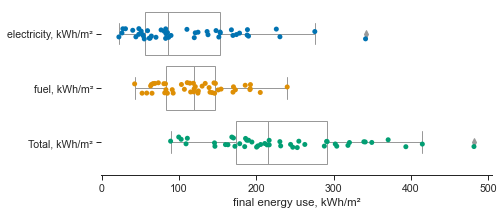

In [113]:
fig, ax = plt.subplots(figsize=(7, 3))

df_benchmark = (df_offices_bxl
                .drop(["area, m²", "electricity, MWh", "fuel, MWh"], axis=1)
                .stack().to_frame("energy use").reset_index()
                .rename(columns={"level_1": "energy type"}).set_index("No")
                )

# Category plot:
ax = sns.boxplot(data=df_benchmark, x="energy use",
                 y="energy type", color='white')

ax = sns.stripplot(data=df_benchmark, x="energy use", y="energy type",
                   palette="colorblind"
                   )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

ax.set(ylabel="", xlabel="final energy use, kWh/m²")
plt.xticks(np.arange(0, 501, 100))
sns.despine(left=True, offset=5)

Compare benchmark with simulation results, first with the initial hvac system:

In [114]:
# Steps 1, 2 and 3, initial hvac system:
df_hvac_init = df_end_use_allsteps[["a", "b", "c"]]

In [115]:
# Add total energy use per energy supplier, and convert in kWh/m²:
df_hvac_init = (df_hvac_init.append(df_hvac_init.sum().rename('Total'))
                / net_conditioned_area * 278
                )

In [116]:
# Reorganise the df:
df_hvac_init = (
    df_hvac_init.loc["Total"].to_frame("energy use").reset_index()
    .drop("Step", axis=1)
)

df_hvac_init = pd.pivot_table(df_hvac_init,
                              values='energy use',
                              index=['Run name'], columns=['FuelType']
                              )

In [117]:
# Add a column with total energy use:
df_hvac_init["Total, kWh/m²"] = (
    df_hvac_init["Electricity"] + df_hvac_init["Natural Gas"]
)

df_hvac_init = df_hvac_init.stack().to_frame(
    "energy use").reset_index().set_index("Run name")

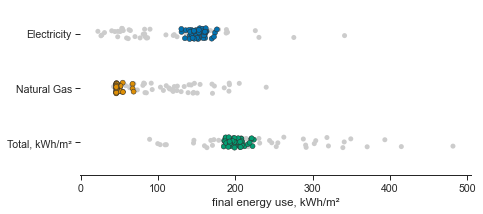

In [118]:
fig, ax = plt.subplots(figsize=(7, 3))


ax = sns.stripplot(data=df_benchmark, x="energy use", y="energy type",
                   color=".8")

ax = sns.stripplot(data=df_hvac_init, x="energy use", y="FuelType",
                   palette="colorblind",
                   linewidth=0.5
                   )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

ax.set(ylabel="", xlabel="final energy use, kWh/m²")
plt.xticks(np.arange(0, 501, 100))
sns.despine(left=True, offset=5)

Compare benchmark with simulation results, with the vav optimised hvac system:

In [119]:
df_hvac_vav = df_end_use_allsteps[["d", "e"]]

In [120]:
# Add total energy use per energy supplier, and convert in kWh/m²:
df_hvac_vav = (df_hvac_vav.append(df_hvac_vav.sum().rename('Total'))
               / net_conditioned_area * 278
               )

In [121]:
# Reorganise the df:
df_hvac_vav = (
    df_hvac_vav.loc["Total"].to_frame("energy use").reset_index()
    .drop("Step", axis=1)
)

df_hvac_vav = pd.pivot_table(df_hvac_vav,
                             values='energy use',
                             index=['Run name'], columns=['FuelType']
                             )

In [122]:
# Add a column with total energy use:
df_hvac_vav["Total, kWh/m²"] = (
    df_hvac_vav["Electricity"] + df_hvac_vav["Natural Gas"]
)

df_hvac_vav = df_hvac_vav.stack().to_frame(
    "energy use").reset_index().set_index("Run name")

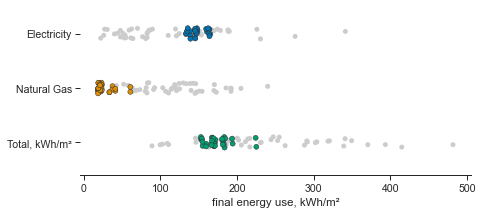

In [123]:
fig, ax = plt.subplots(figsize=(7, 3))


ax = sns.stripplot(data=df_benchmark, x="energy use", y="energy type",
                   color=".8")

ax = sns.stripplot(data=df_hvac_vav, x="energy use", y="FuelType",
                   palette="colorblind",
                   linewidth=0.5
                   )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

ax.set(ylabel="", xlabel="final energy use, kWh/m²")
plt.xticks(np.arange(0, 501, 100))
sns.despine(left=True, offset=5)

## Comparative Analysis Step by Step

### Step 1: Different glazing types, w/o shading devices

Labels for xticks in the next graphs:

In [124]:
labels = [enduse for enduse in df_end_use_allsteps.index]
n_ref = []
for i in range(len(labels)):
    n_ref.append(i + 1)
    print(labels[i], ":", n_ref[i])

Cooling : 1
Fans : 2
Heat Rejection : 3
Heating : 4
Interior Equipment : 5
Interior Lighting : 6
Pumps : 7


In the following graphs, blue is used to represent electricity use, while red corresponds to natural gas use.

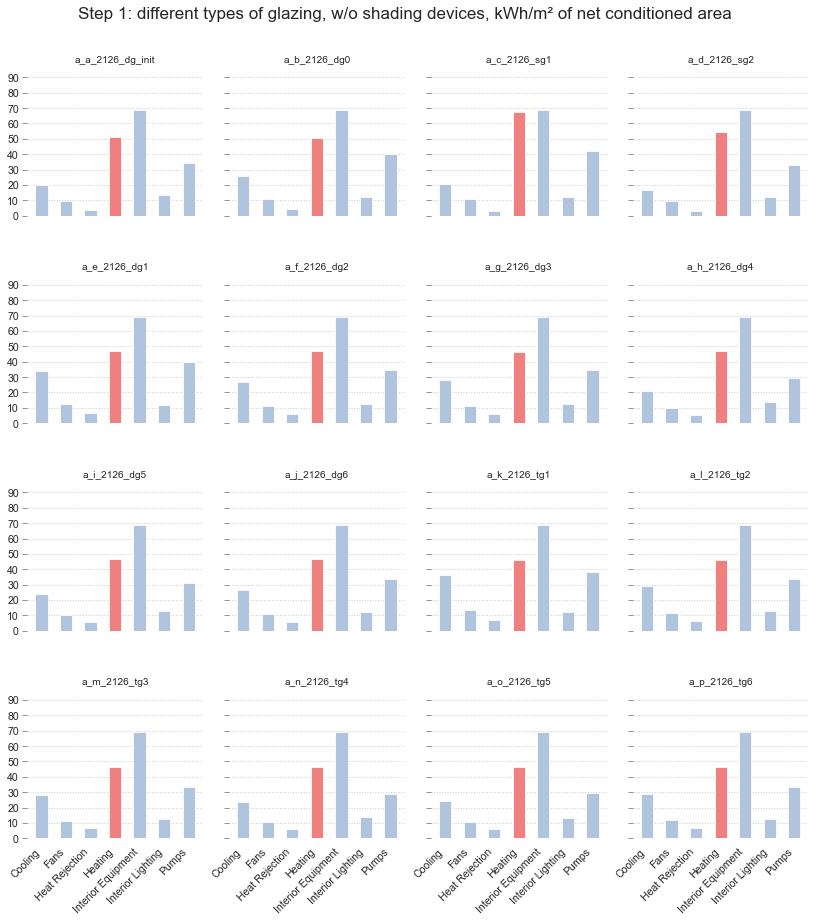

In [125]:
code = "a"
ylim = 90
title = ("Step 1: different types of glazing," +
         " w/o shading devices," +
         " kWh/m² of net conditioned area")

# Vertical bar chart with all end uses:
end_use_v_plot(code, df_end_use_allsteps, ylim, title)

### Step 1-3: Different Glazing Types, Old HVAC System

In [126]:
ylim = 90
dict_plot = {
    "a":
    "Step 1: w/o shading devices, kWh/m² of net conditioned area",
    "b":
    "Step 2: with interior shading devices, kWh/m² of conditioned area",
    "c":
    "Step 3: with exterior shading devices, kWh/m² of conditioned area"
}

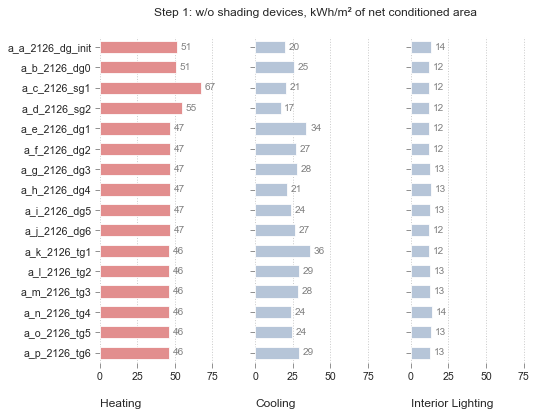

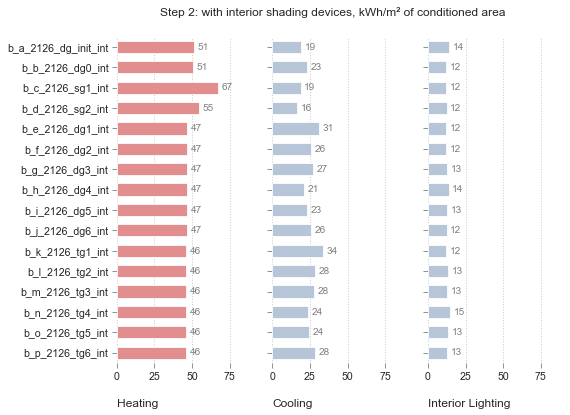

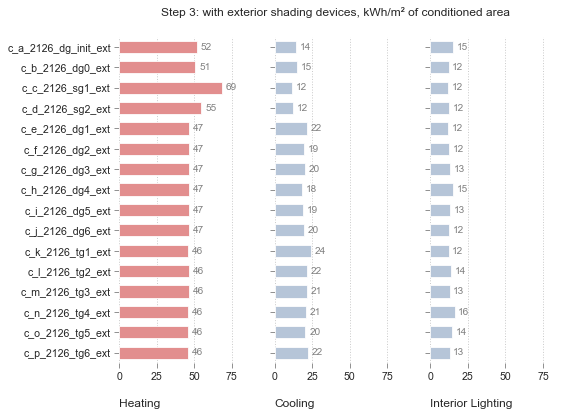

In [127]:
for code, title in dict_plot.items():
    # Another kind of plot with heating and cooling load:
    heat_cool_light_plot(code, df_end_use_allsteps, ylim, title)

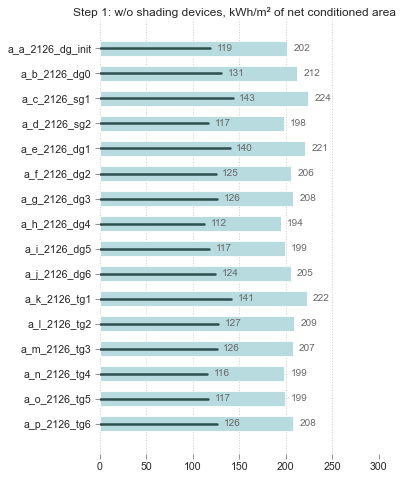

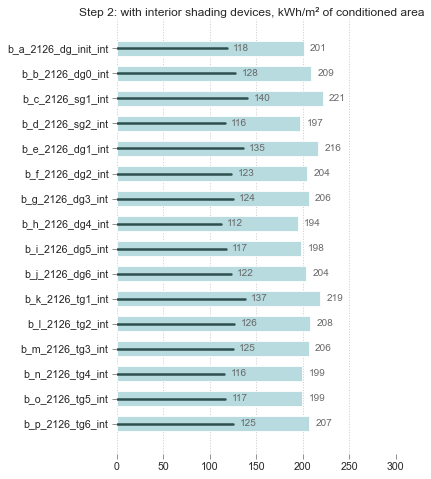

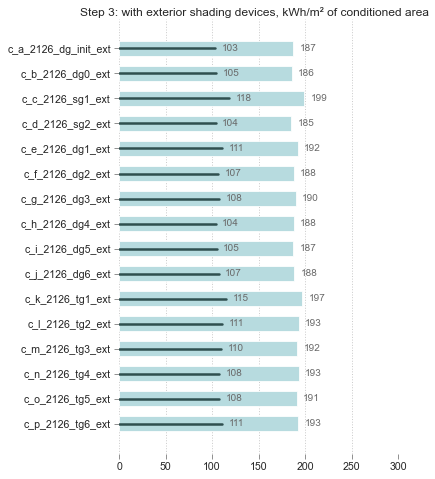

In [128]:
for code, title in dict_plot.items():
    total_end_use_h_plot(code, 300, title)

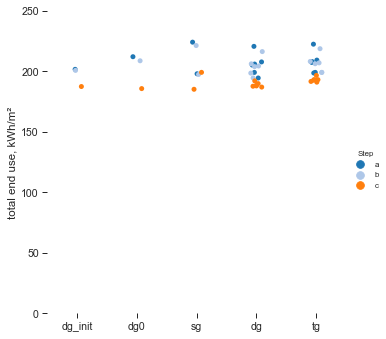

In [129]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 1, 2, 3:
df_plot = df_plot[['a', 'b', 'c']].T.reset_index()

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="tab20", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

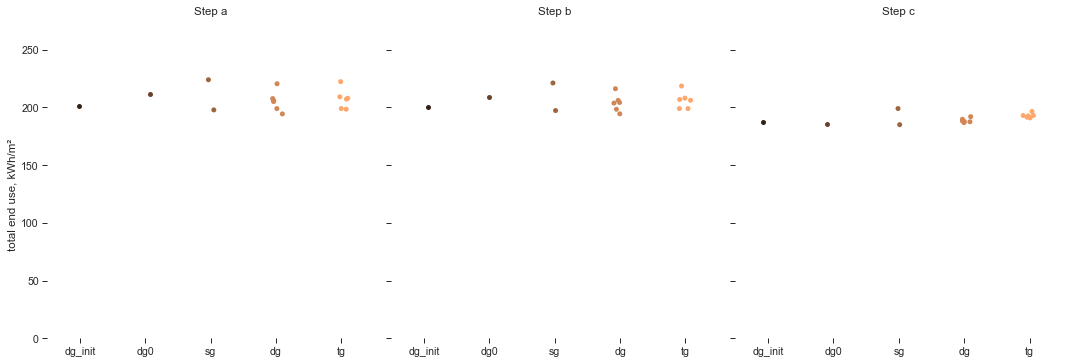

In [130]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 1, 2, 3:
df_plot = df_plot[['a', 'b', 'c']].T.reset_index()

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", col="Step",
                 height=5, aspect=1, palette="copper"
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 4: Efficient VAV w/o shading devices

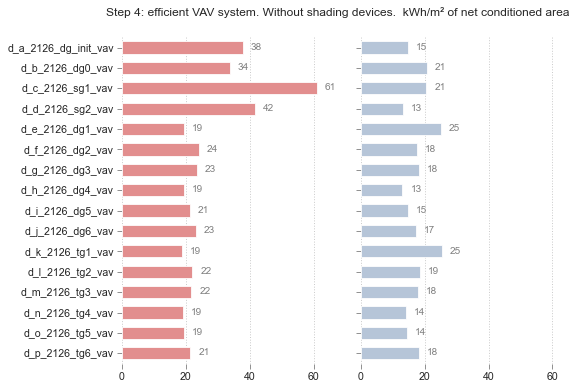

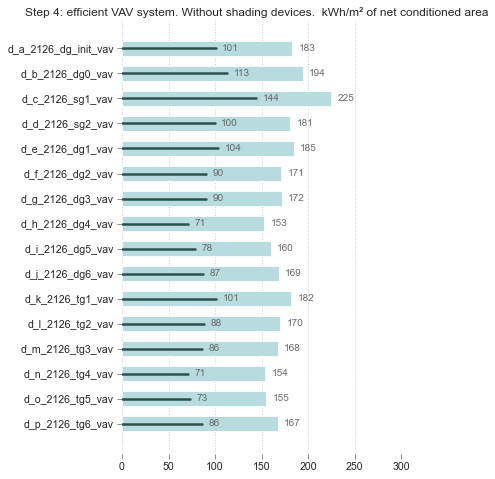

In [131]:
code = "d"
ylim = 65
title = ("Step 4: efficient VAV system. Without shading devices. " +
         " kWh/m² of net conditioned area")

# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 5: Efficient VAV w/ interior shading devices

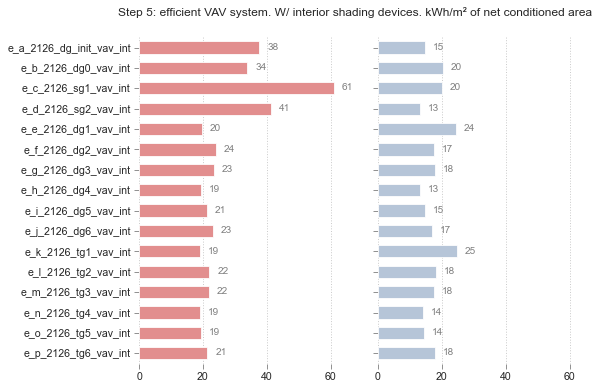

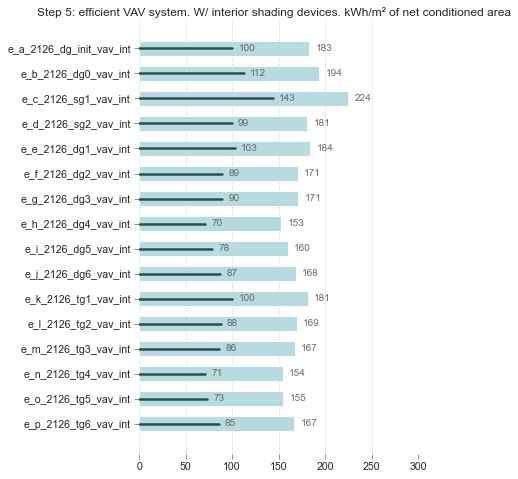

In [132]:
code = "e"
ylim = 65
title = ("Step 5: efficient VAV system. W/ interior shading devices." +
         " kWh/m² of net conditioned area")

# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 6: VRF System, without shading devices

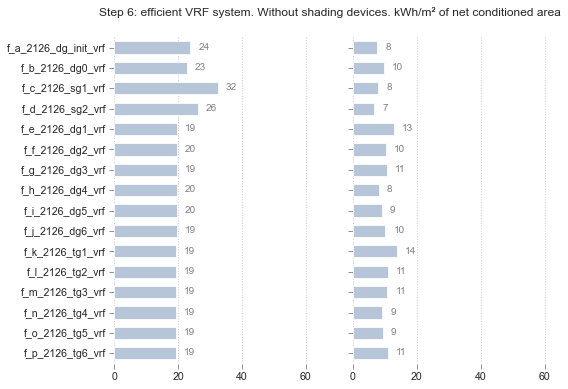

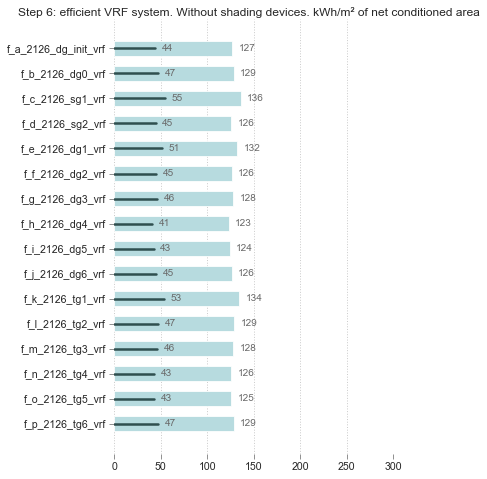

In [133]:
code = "f"
ylim = 65
title = ("Step 6: efficient VRF system. Without shading devices." +
         " kWh/m² of net conditioned area")

# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 7:  VRF System, with interior shading devices

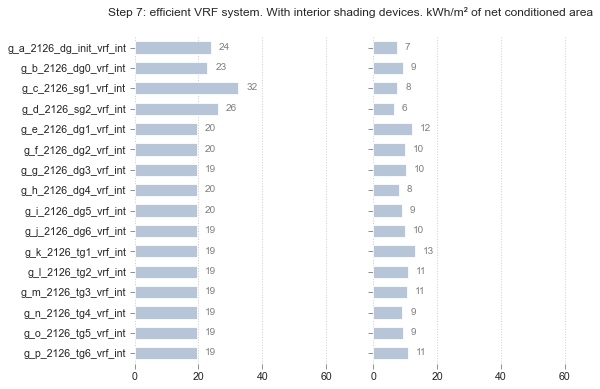

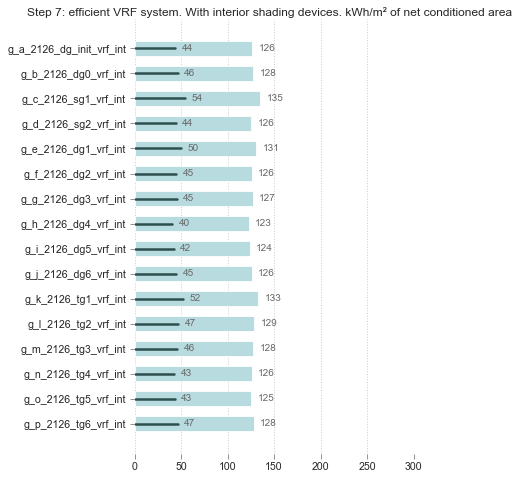

In [134]:
code = "g"
ylim = 65
title = ("Step 7: efficient VRF system. With interior shading devices." +
         " kWh/m² of net conditioned area")

# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### HVAC Systems: Comparative Analysis (old one, VAV, VRF)

Firt, comparative analysis without shading devices:

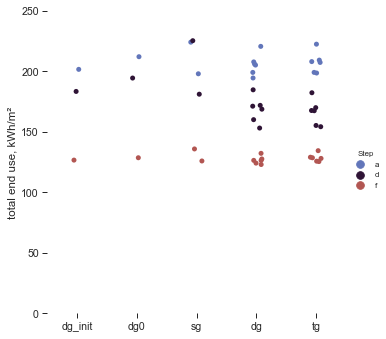

In [135]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only steps 1, 4, 6:
df_plot = df_plot[['a', 'd', 'f']].T.reset_index()

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

Second, comparative analysis with internal shading devices:

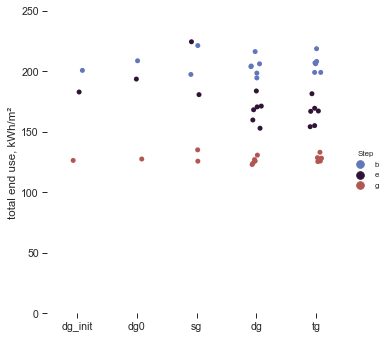

In [136]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 2, 5, 7:
df_plot = df_plot[['b', 'e', 'g']].T.reset_index()

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 8: 75% reduction of the w-to-w ratio

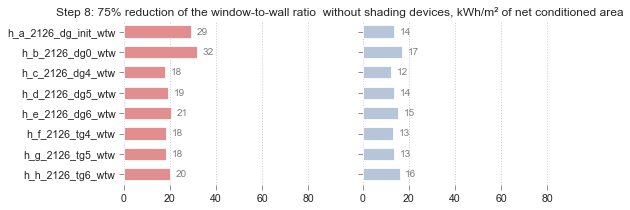

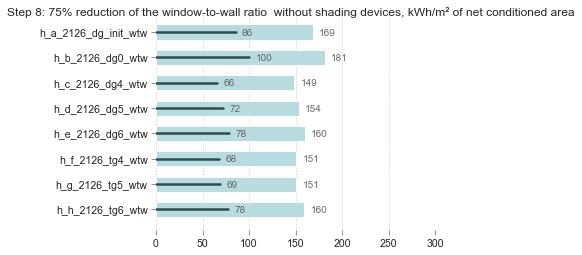

In [137]:
code = "h"
ylim = 90
title = ("Step 8: 75% reduction of the window-to-wall ratio " +
         " without shading devices," +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Window-to-Wall Ratio: Comparative Analysis

With optimised VAV system:
- Fully glazed without shading devices (step d)
- Fully glazed with interior shading devices (step e)
- 75% glazed with shading devices (step h) 

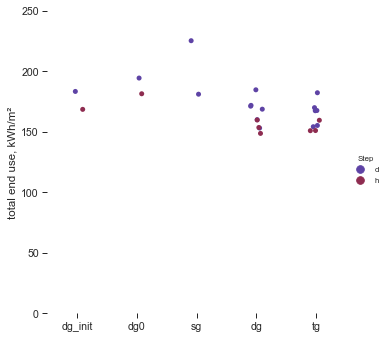

In [138]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only steps 4, 8:
df_plot = df_plot[['d', 'h']].T.reset_index()

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 9: High-Tech Retrofitting

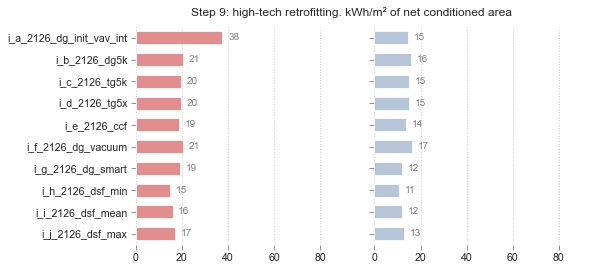

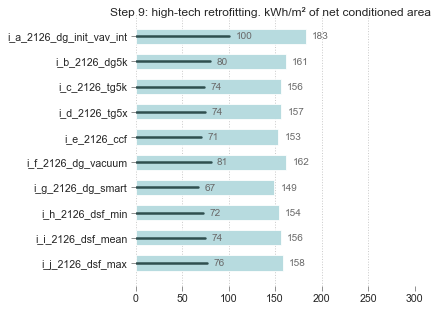

In [139]:
code = "i"
ylim = 90
title = ("Step 9: high-tech retrofitting." +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

To compare with classic IGUs:

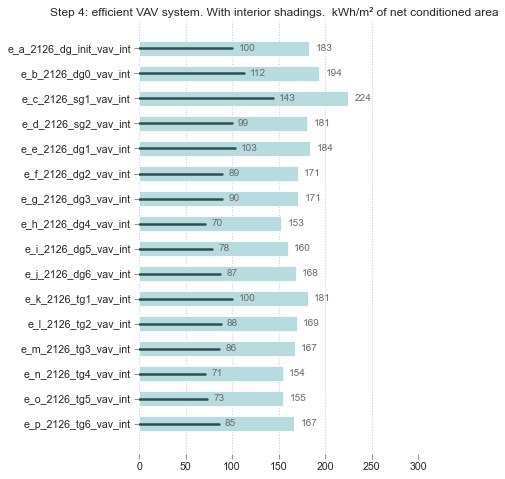

In [140]:
code = "e"
ylim = 90
title = ("Step 4: efficient VAV system. With interior shadings. " +
         " kWh/m² of net conditioned area")

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

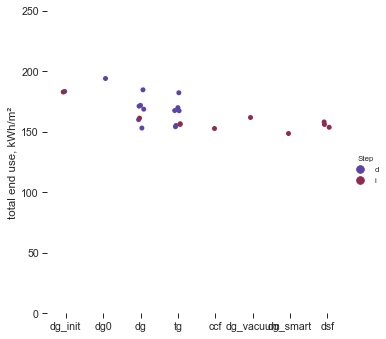

In [141]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 4, 9:
df_plot = df_plot[['d', 'i']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 10: Americanisation

- Cooling setpoint: 24°C
- Heating setpoint: 21°C
- Without shading devices

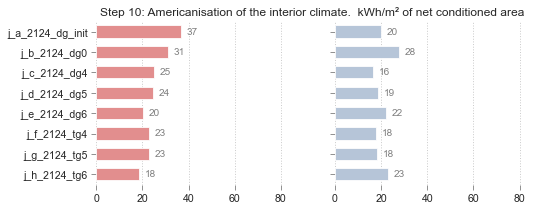

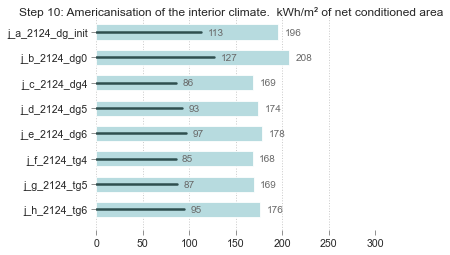

In [142]:
code = "j"
ylim = 90
title = ("Step 10: Americanisation of the interior climate. " +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 11: sufficiency path

- Cooling setpoint: 27°C
- Heating setpoint: 19°C
- With exterior shading devices

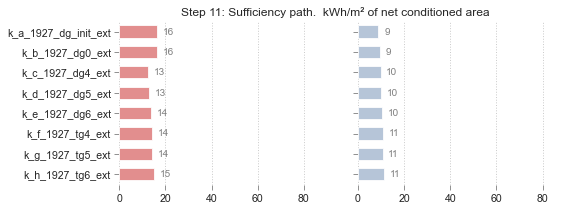

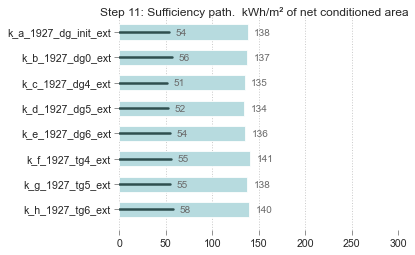

In [143]:
code = "k"
ylim = 90
title = ("Step 11: Sufficiency path. " +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Indoor Climate: Comparative Analysis

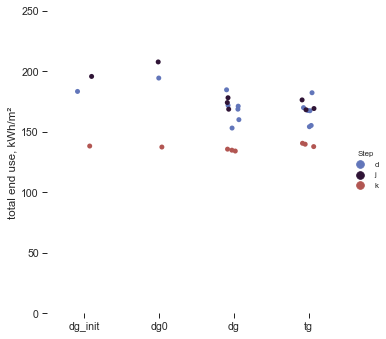

In [144]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 4, 10, 11:
df_plot = df_plot[['d', 'j', 'k']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 12: Increase of the internal gains

- Step 12: Increase of the internal gains. Density of 6.5 m²/p. instead of 10m²/p; lighting power of 10 W/m² instead of 8 W/m².

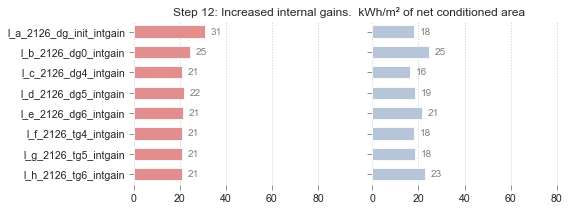

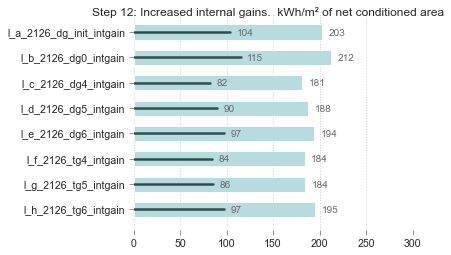

In [146]:
code = "l"
ylim = 90
title = ("Step 12: Increased internal gains. " +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Step 13: Decrease of the internal gains

- Step 13: Decrease of the internal gains. Density of 10 m²/p. instead of 8m²/p; lighting power of 5 W/m² instead of 8 W/m².

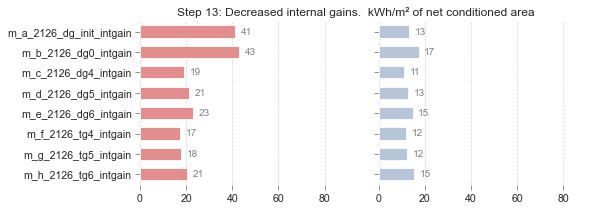

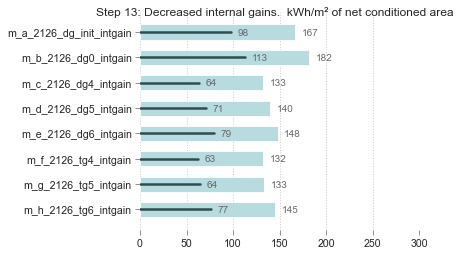

In [147]:
code = "m"
ylim = 90
title = ("Step 13: Decreased internal gains. " +
         " kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Internal Gains: Comparative Analysis

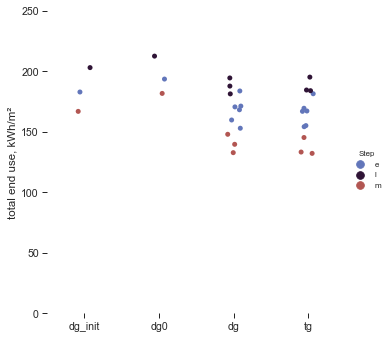

In [148]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 5, 12, 13:
df_plot = df_plot[['e', 'l', 'm']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

### Step 14-16: Climate Change (2069-2098 - RCP 8.5)

- Step 14: Include interior shading devices. Cooling setpoint 26°C, heating setpoint 19°C.
- Step 16: Without shading devices. Cooling setpoint 24°C, heating setpoint 21°C.
- Step 18: Include exterior shading devices. Cooling setpoint 27°C, heating setpoint 19°C.

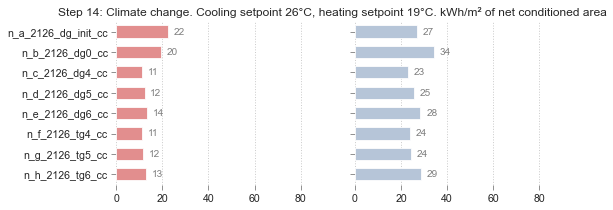

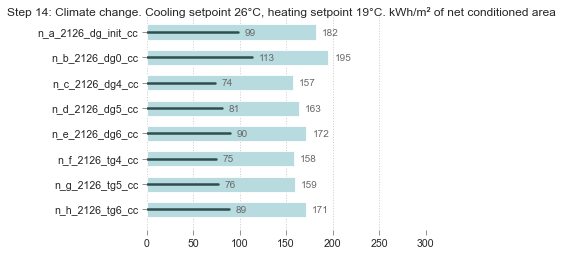

In [150]:
code = "n"
ylim = 90
title = ("Step 14: Climate change. "
         + "Cooling setpoint 26°C, heating setpoint 19°C. "
         + "kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

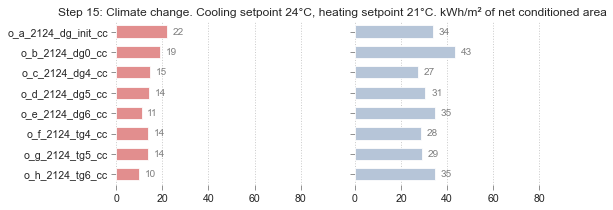

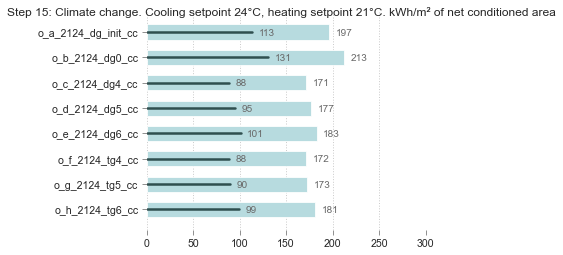

In [151]:
code = "o"
ylim = 90
title = ("Step 15: Climate change. "
         + "Cooling setpoint 24°C, heating setpoint 21°C. "
         + "kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

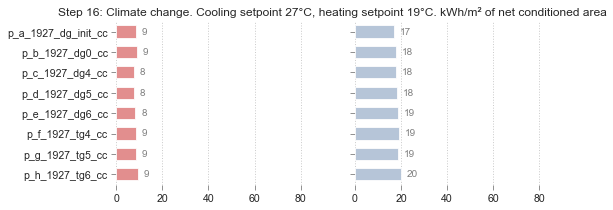

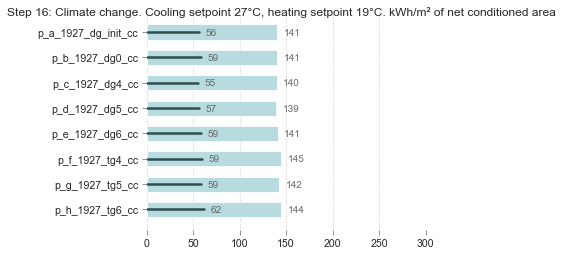

In [152]:
code = "p"
ylim = 90
title = ("Step 16: Climate change. "
         + "Cooling setpoint 27°C, heating setpoint 19°C. "
         + "kWh/m² of net conditioned area")

print("\n\n")
# Another kind of plot with heating and cooling load:
heat_cool_h_plot(code, df_end_use_allsteps, ylim, title)

print("\n\n")
# Horizontal bar chart with total energy use,
# w/ indications of cooling+heating load, and total hvac kind:
total_end_use_h_plot(code, 300, title)

### Climate Change, Comparative Analysis

Scenario: Include interior shading devices. Cooling setpoint 26°C, heating setpoint 21°C.

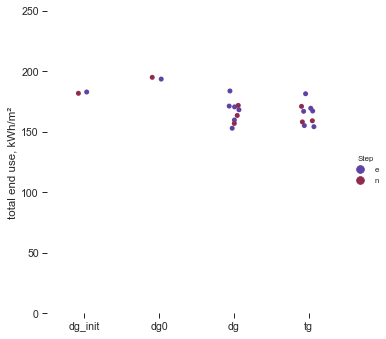

In [153]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 5, 14:
df_plot = df_plot[['e', 'n']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

Scenario: No shading devices. Cooling setpoint 24°C, heating setpoint 21°C.

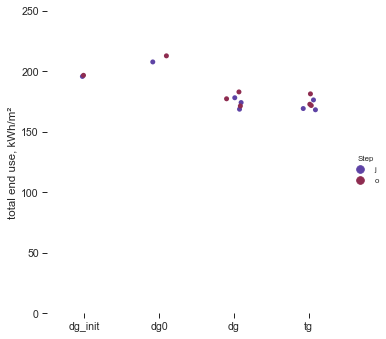

In [154]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 10, 15:
df_plot = df_plot[['j', 'o']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

Scenario: Include exterior shading devices. Cooling setpoint 27°C, heating setpoint 19°C.

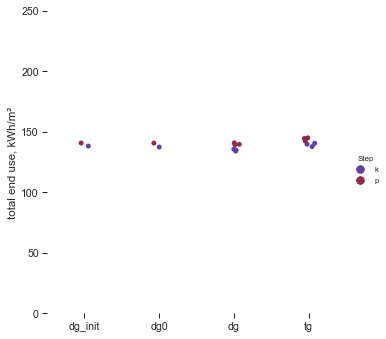

In [155]:
# Convert to kWh/m²:
df_plot = (df_end_use_total / net_conditioned_area * 278)
# Consider only step 11, 16:
df_plot = df_plot[['k', 'p']].T.reset_index()
# Drop single glazing:
df_plot = df_plot[df_plot.IGU != "sg"]

# Category plot:
ax = sns.catplot(data=df_plot, x="IGU", y="Total", hue="Step",
                 # kind="point", capsize=.1,
                 palette="twilight", height=5, aspect=1
                 )

# palette=sns.color_palette(['firebrick', 'lightcoral', 'royalblue'])

(ax.set_axis_labels("", "total end use, kWh/m²")
 .set_titles("{col_var} {col_name}", fontsize=17, y=1.1)
 .set(ylim=(0, 250))
 .despine(left=True, bottom=True, offset=5)
 )
plt.show()

## Heat Gain and Heat Loss through Windows

### Setup to recover useful data

First, the Outdoor Air Drybulb Temperature:

In [156]:
temp_vars = ['Site Outdoor Air Drybulb Temperature']
# Find the output data from the last simulation run:
eplus_sql = EPLusSQL(sql_path=str(Path('outputs/energyplus/eplusout.sql')))
# Define a DataFrame with temperature:
df_temp = eplus_sql.get_hourly_variables(variables_list=temp_vars)

In [157]:
# Clean the DataFrame and mean the temperature per hour:
df_temp.columns = df_temp.columns.droplevel("Units")
df_temp.columns = df_temp.columns.droplevel("KeyValue")

<AxesSubplot:>

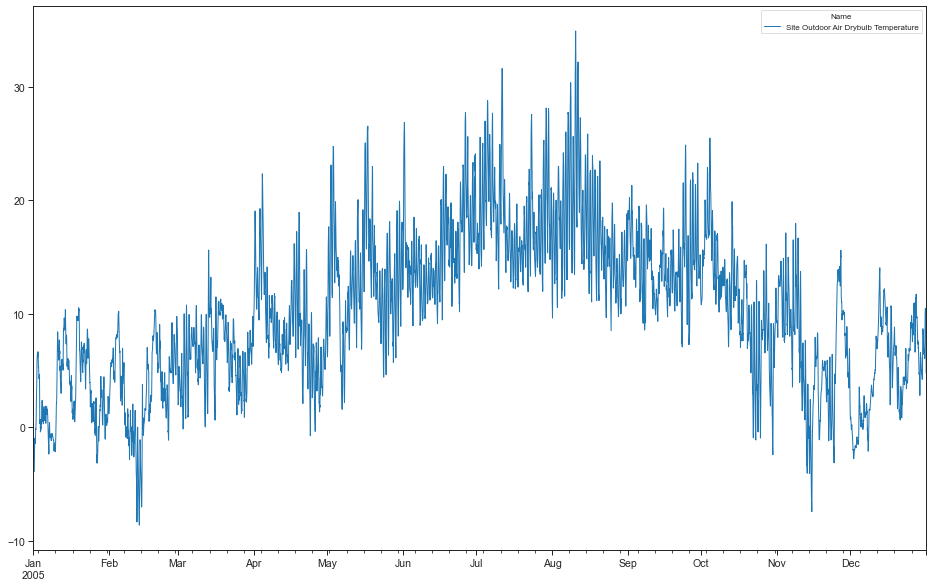

In [158]:
df_temp.plot()

In [159]:
# Define a dataframe with temperature during daytime (8am 8pm), mean per day:
df_temp_d = df_temp.between_time('8:00', '20:00')
df_temp_d = df_temp_d.resample('D').mean()

Define a function to recover the hourly reporting variables from the csv file saved after each simulation run:

In [160]:
def recover_df_hourly(run_code):
    """
    Define a Dataframe from the df_h_run.csv, where hourly reporting 
    variables have been saved for each simulation run  

    Parameters
    ----------
    run_code: code of the simulation run
    df_h_run: a dataframe. followed by a code (e.g. "b_e"), 
        where hourly reporting variables will be saved


    Returns
    -------
    df_h_run

    """

    # Does the csv exist
    # And define the df_h_run:
    if os.path.isfile(f"outputs\steps_dir\df_h_run_"+str(run_code)+".csv"):
        df_h_run = (
            pd.read_csv(f"outputs\steps_dir\df_h_run_"+str(run_code)+".csv",
                        header=[0, 1, 2], index_col=0)
        )

        # Converting the index as date
        df_h_run.index = pd.to_datetime(df_h_run.index)

    else:
        print("df_h_run does not exist")

    return df_h_run

Define a function to get a dataframe only with heat gain/loss through the windows in the whole building, per day from 8am to 8pm:

In [161]:
def df_heat_window(df_h_run):
    """
    Define a Dataframe from the df_h_run (hourly reporting 
    variables). The resulting df_heat_window has two columns:
    > 'Total Heat Gain, J'
    > 'Total Heat Loss, J'
    These data are the sum for the whole bldg, per day.

    Parameters
    ----------
    df_h_run: a dataframe. followed by a code (e.g. "b_e"), 
        where hourly reporting variables will be saved

    Returns
    -------
    df_heat_window: a DataFrame w/ Windows Total Heat Gain/Loss Energy.

    """

    # Define a DataFrame w/ Windows Total Heat Gain/Loss Energy
    df_window = df_h_run.groupby(level=1, axis=1).sum()
    df_window = df_window.loc[:, df_window.columns.intersection(
        ['Zone Windows Total Heat Gain Energy',
         'Zone Windows Total Heat Loss Energy'])]

    # Consider only heat gain/loss btw 8h and 20h, i.e. daytime
    df_window = df_window.between_time('8:00', '20:00')
    df_window = df_window.resample('D').sum().rename(
        columns={'Zone Windows Total Heat Gain Energy': 'Total Heat Gain, J',
                 'Zone Windows Total Heat Loss Energy': 'Total Heat Loss, J'})

    return df_window

### Analysis of the Heat Transfers with or without Shading Devices

Corresponds to the step1 simulations.

In [162]:
run_code = "a_a"
df_h_run_a_a = recover_df_hourly(run_code)

In [163]:
df_window_a_a = df_heat_window(df_h_run_a_a)

<AxesSubplot:xlabel='Count', ylabel='Total Heat Loss, J'>

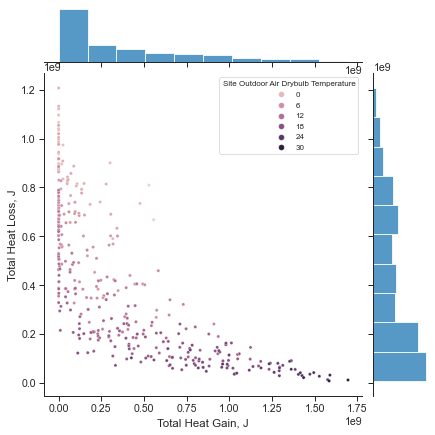

In [164]:
df_plot = pd.concat([df_window_a_a, df_temp_d], axis=1)
g = sns.JointGrid()
x, y, z = (df_plot["Total Heat Gain, J"],
           df_plot["Total Heat Loss, J"],
           df_plot["Site Outdoor Air Drybulb Temperature"])
sns.scatterplot(x=x, y=y, hue=z, s=10, ax=g.ax_joint)
sns.histplot(x=x, ax=g.ax_marg_x)
sns.histplot(y=y, ax=g.ax_marg_y)

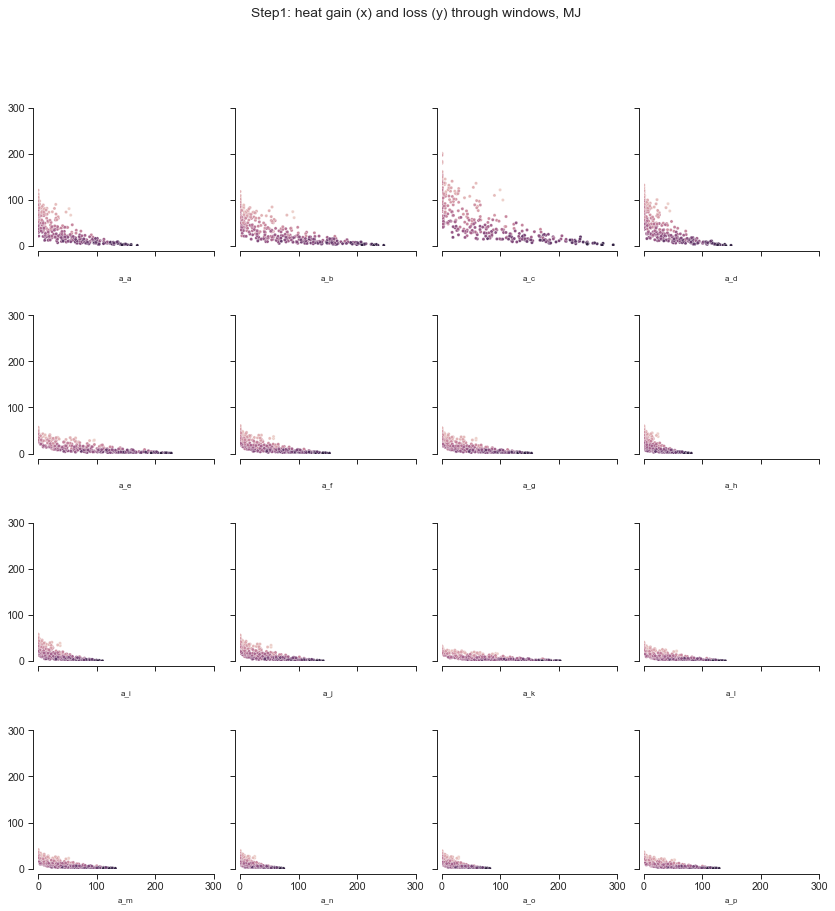

In [165]:
ls_code_plot = ["a_a", "a_b", "a_c", "a_d",
                "a_e", "a_f", "a_g", "a_h",
                "a_i", "a_j", "a_k", "a_l",
                "a_m", "a_n", "a_o", "a_p"]

fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_window = df_heat_window(df_h)

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_window, df_temp_d], axis=1)

        # Plot with JointGrid:
        x, y, z = (df_plot["Total Heat Gain, J"]/10e+6,
                   df_plot["Total Heat Loss, J"]/10e+6,
                   df_plot["Site Outdoor Air Drybulb Temperature"])
        sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)

        ax.set_title(f"{ls_code_plot[n]}", y=-0.35, pad=15)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

ax.set_xlim(0, 300)
plt.xticks(np.arange(0, 301, 100))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step1: heat gain (x) and loss (y) through windows, MJ')
sns.despine(offset=5)
plt.show()

### Analysis of the Heat Transfers with Interior Shading Devices

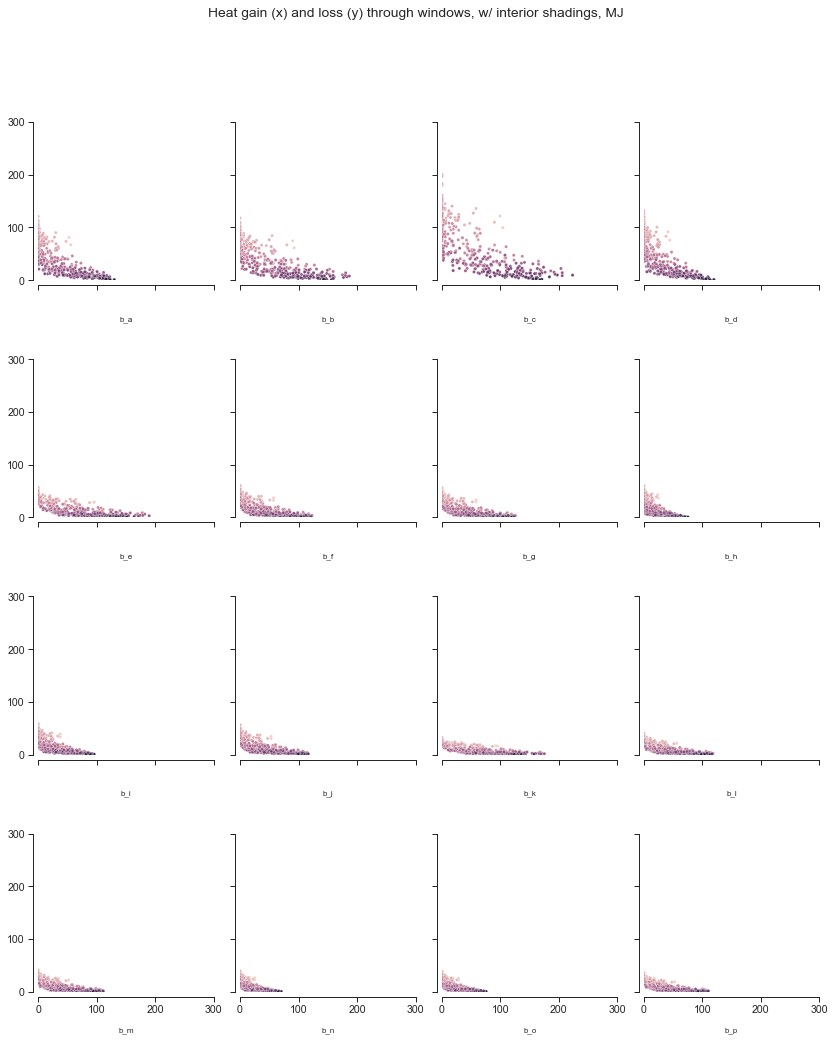

In [166]:
ls_code_plot = ["b_a", "b_b", "b_c", "b_d",
                "b_e", "b_f", "b_g", "b_h",
                "b_i", "b_j", "b_k", "b_l",
                "b_m", "b_n", "b_o", "b_p"
                ]

fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(14, 16))

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_window = df_heat_window(df_h)

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_window, df_temp_d], axis=1)

        # Plot with JointGrid:
        x, y, z = (df_plot["Total Heat Gain, J"]/10e+6,
                   df_plot["Total Heat Loss, J"]/10e+6,
                   df_plot["Site Outdoor Air Drybulb Temperature"])
        sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)

        ax.set_title(f"{ls_code_plot[n]}", y=-0.35, pad=15)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

ax.set_xlim(0, 300)
plt.xticks(np.arange(0, 301, 100))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle(
    'Heat gain (x) and loss (y) through windows, w/ interior shadings, MJ'
)
sns.despine(offset=5)
plt.show()

### Analysis of the Heat Transfers with Exterior Shading Devices

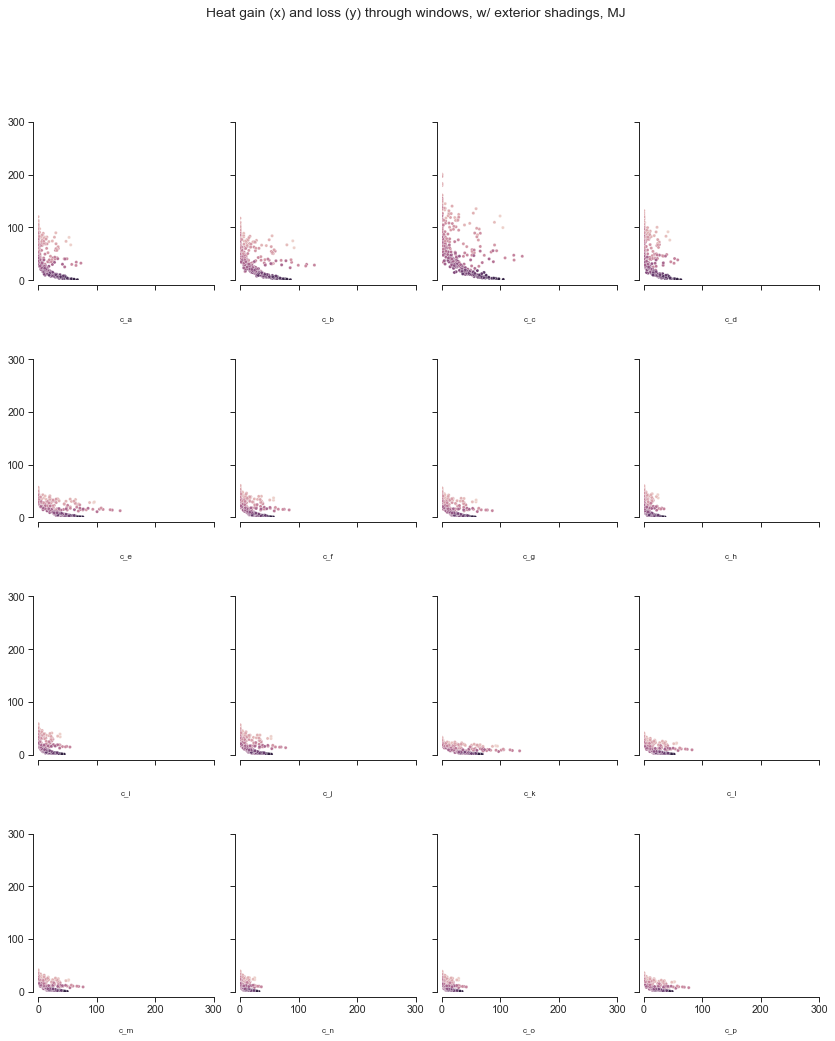

In [167]:
ls_code_plot = ["c_a", "c_b", "c_c", "c_d",
                "c_e", "c_f", "c_g", "c_h",
                "c_i", "c_j", "c_k", "c_l",
                "c_m", "c_n", "c_o", "c_p"
                ]

fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(14, 16))

n = 0

for row in range(4):
    for col in range(4):
        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_window = df_heat_window(df_h)

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_window, df_temp_d], axis=1)

        # Plot with JointGrid:
        x, y, z = (df_plot["Total Heat Gain, J"]/10e+6,
                   df_plot["Total Heat Loss, J"]/10e+6,
                   df_plot["Site Outdoor Air Drybulb Temperature"])
        sns.scatterplot(x=x, y=y, hue=z, s=10, ax=ax)

        ax.set_title(f"{ls_code_plot[n]}", y=-0.35, pad=15)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        ax.get_legend().remove()

        n += 1

ax.set_ylim(0, 300)
plt.yticks(np.arange(0, 301, 100))

ax.set_xlim(0, 300)
plt.xticks(np.arange(0, 301, 100))

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle(
    'Heat gain (x) and loss (y) through windows, w/ exterior shadings, MJ'
)
sns.despine(offset=5)
plt.show()

## Chiller and Boiler Energy Use

We first compare steps 5, 10 and 11, which are with a VAV HVAC system. The first one with T° setpoints of 26°C and 21°C w/ interior shadings, the next one of 24°C and 21°C without shading, the last one of 27°C and 19°C with exterior shading.

In [168]:
ls_code_plot = ["e_a", "e_b", "e_h", "e_i", "e_j", "e_n", "e_o", "e_p",
                "j_a", "j_b", "j_c", "j_d", "j_e", "j_f", "j_g", "j_h",
                "k_a", "k_b", "k_c", "k_d", "k_e", "k_f", "k_g", "k_h",
                ]

### Comparative Analysis, Chiller

Analysis of the use of the chiller according to the day, over a year:

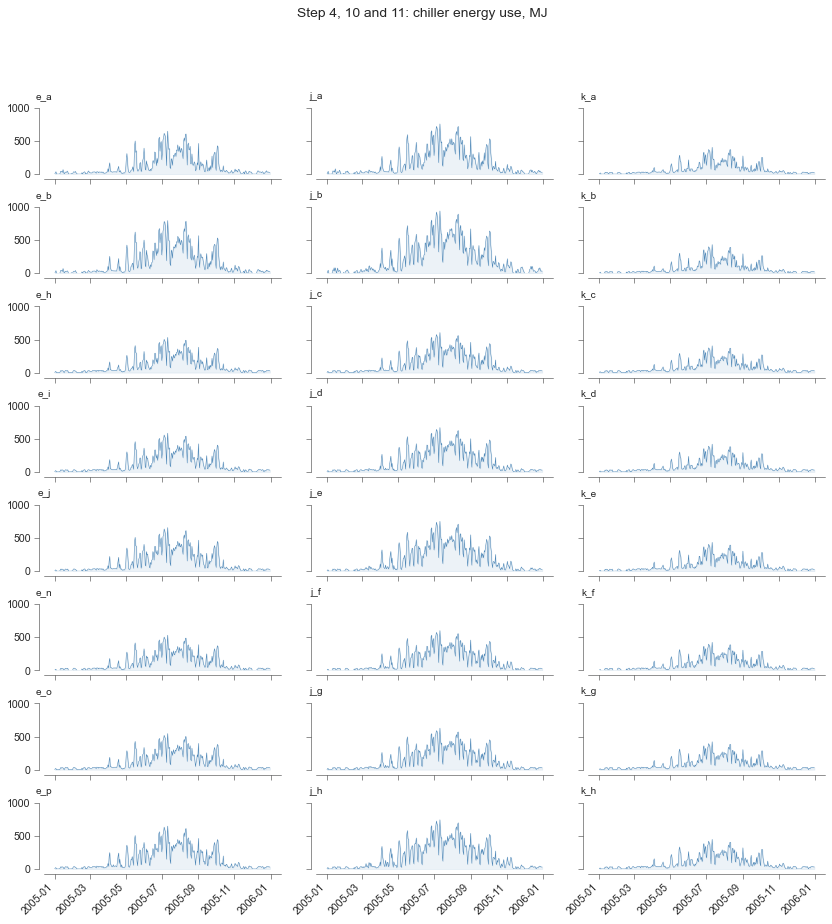

In [169]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_heat_cool, df_temp_d], axis=1)

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=df_plot.index,
                     y=yc,
                     color="steelblue",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(df_plot.index, yc, color="steelblue", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1


fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]
        ax.set_ylim(0, 1000)
        plt.yticks(np.arange(0, 1001, 500))

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

plt.show()

Analysis of the use of the chiller according to the outdoor temperature, over a year:

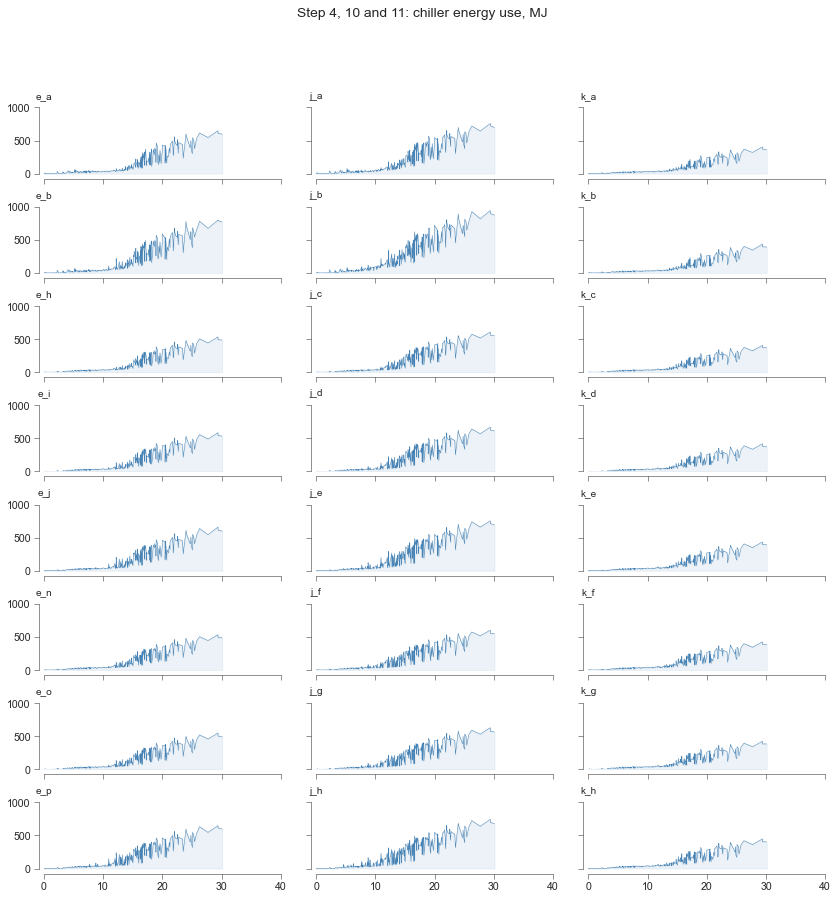

In [170]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat(
            [df_heat_cool, df_temp_d], axis=1
        ).sort_values(by=["Site Outdoor Air Drybulb Temperature"])

        x = df_plot["Site Outdoor Air Drybulb Temperature"]

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=x,
                     y=yc,
                     color="steelblue",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(x, yc, color="steelblue", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]

        ax.set_xlim(0, 40)
        plt.xticks(np.arange(0, 41, 10))

        ax.set_ylim(0, 1000)
        plt.yticks(np.arange(0, 1001, 500))

plt.show()

### Comparative Analysis, Boiler

Analysis of the use of the boiler according to the day, over a year:

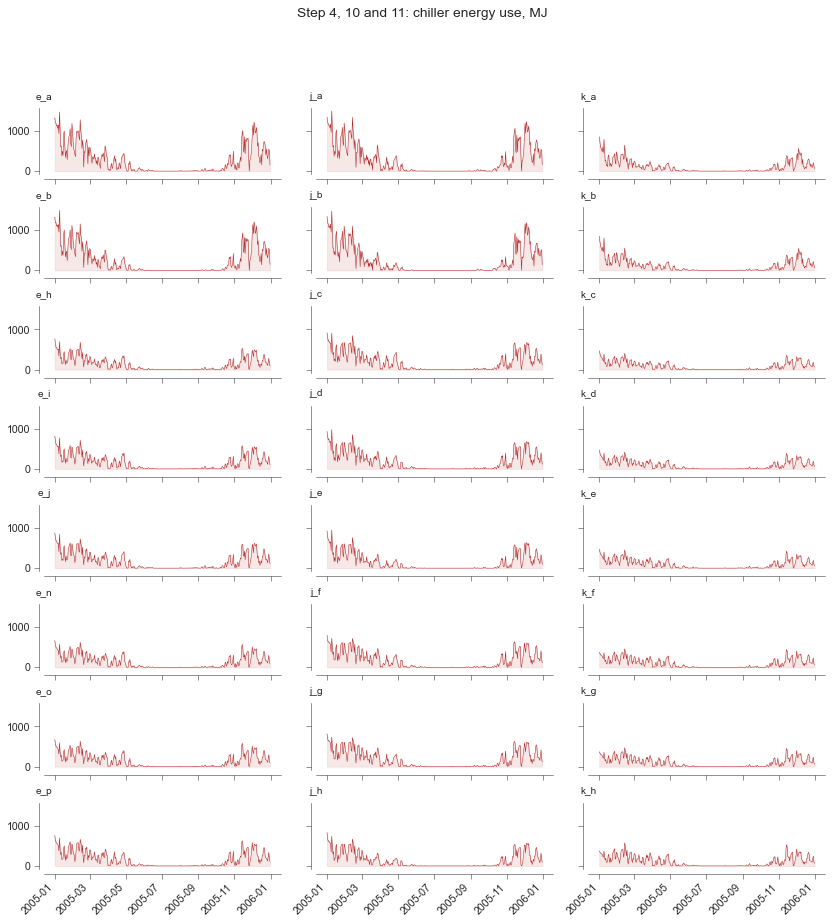

In [171]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_heat_cool, df_temp_d], axis=1)

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=df_plot.index,
                     y=yb,
                     color="firebrick",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(df_plot.index, yb, color="firebrick", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

plt.show()

Analysis of the use of the boiler according to the outdoor temperature, over a year:

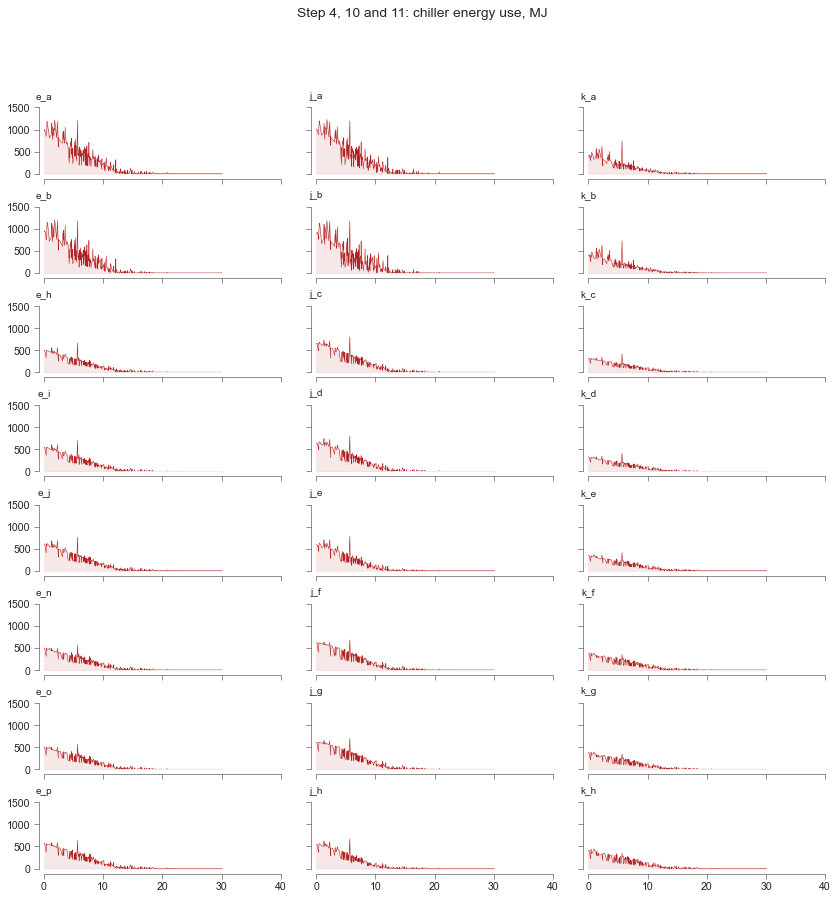

In [172]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat(
            [df_heat_cool, df_temp_d], axis=1
        ).sort_values(by=["Site Outdoor Air Drybulb Temperature"])

        x = df_plot["Site Outdoor Air Drybulb Temperature"]

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=x,
                     y=yb,
                     color="firebrick",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(x, yb, color="firebrick", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1


fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]

        ax.set_xlim(0, 40)
        plt.xticks(np.arange(0, 41, 10))

        ax.set_ylim(0, 1500)
        plt.yticks(np.arange(0, 1501, 500))

plt.show()

### Impact of Climate Change RCP 8.5

Here, we compare steps 5, 14, 15 and 16, which are with a VAV HVAC system. The first one with T° setpoints of 26°C and 21°C w/ interior shadings.
Steps 14, 15 and 16 take into account RCP 8.5 for Brussels. Step 14 with T° setpoints of 26°C and 21°C w/ interior shadings, step 15 with T° setpoint of 24°C and 21°C without shading, and the last one 27°C and 19°C with exterior shading.

In [173]:
ls_code_cc_plot = ["e_a", "e_b", "e_h", "e_i", "e_j", "e_n", "e_o", "e_p",
                   "n_a", "n_b", "n_c", "n_d", "n_e", "n_f", "n_g", "n_h",
                   "o_a", "o_b", "o_c", "o_d", "o_e", "o_f", "o_g", "o_h",
                   "p_a", "p_b", "p_c", "p_d", "p_e", "p_f", "p_g", "p_h",
                   ]

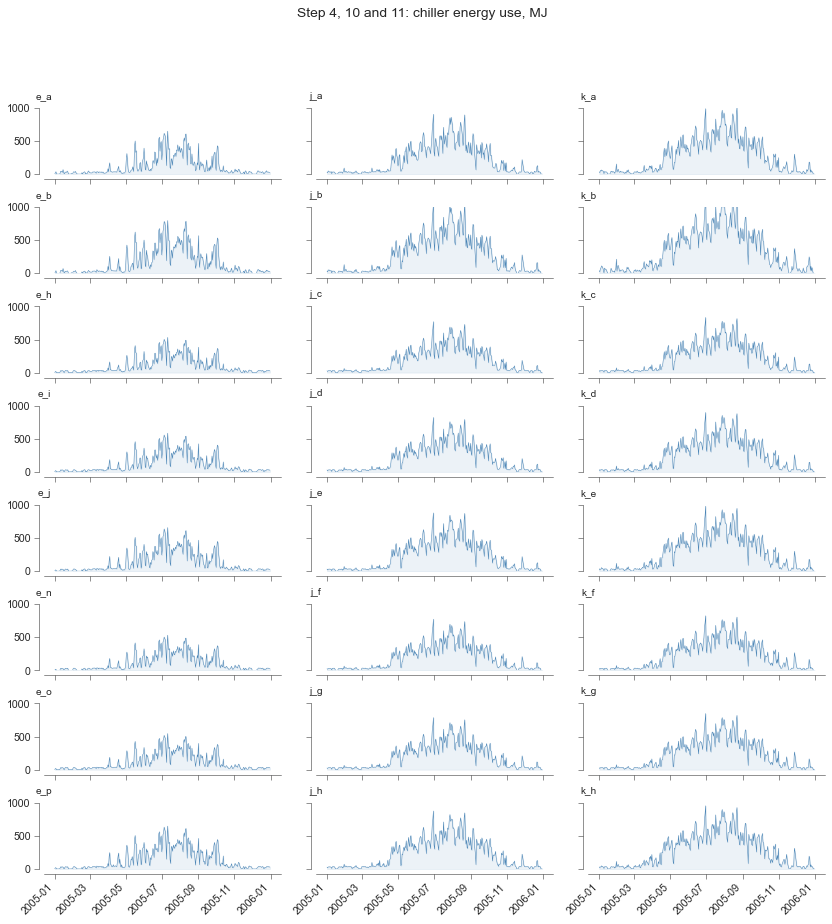

In [174]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_cc_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_heat_cool, df_temp_d], axis=1)

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=df_plot.index,
                     y=yc,
                     color="steelblue",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(df_plot.index, yc, color="steelblue", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1


fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]
        ax.set_ylim(0, 1000)
        plt.yticks(np.arange(0, 1001, 500))

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

plt.show()

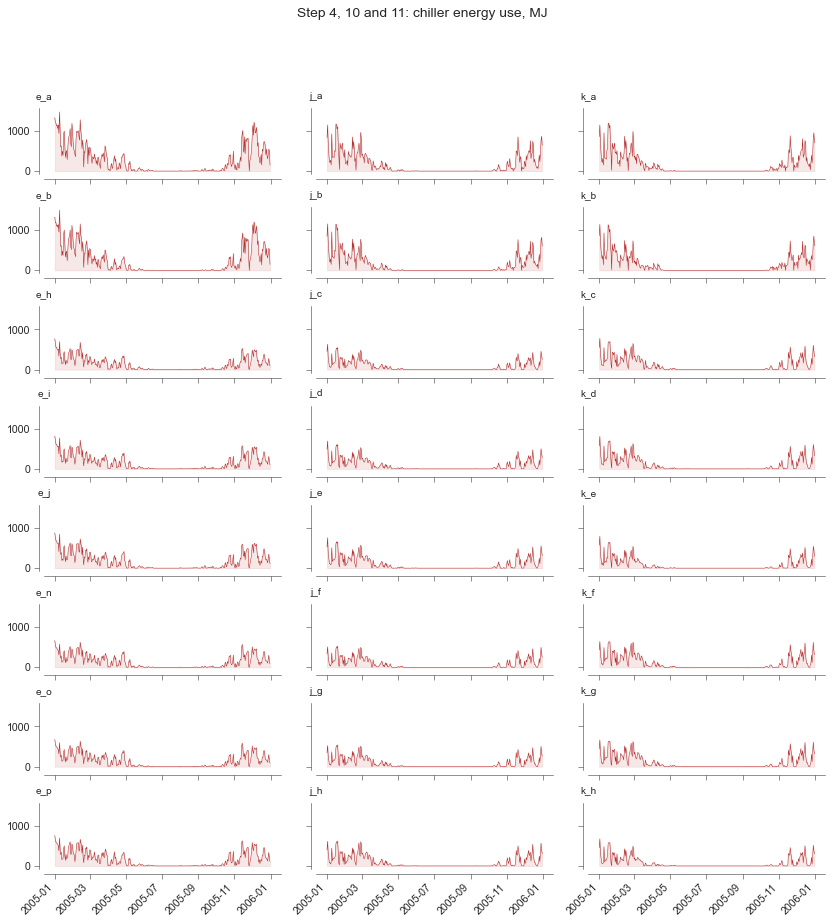

In [175]:
fig, axes = plt.subplots(nrows=8, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(14, 14))

n = 0

for col in range(3):
    for row in range(8):

        ax = axes[row][col]

        df_h = recover_df_hourly(ls_code_cc_plot[n])
        df_h = df_h.groupby(level=1, axis=1).sum()
        df_heat_cool = df_h.loc[:, df_h.columns.intersection(
            ['Chiller Electricity Energy', 'Boiler Heating Energy']
        )
        ]

        df_heat_cool = df_heat_cool.resample('D').sum().rename(
            columns={'Chiller Electricity Energy': 'Chiller, J',
                     'Boiler Heating Energy': 'Boiler, J'}
        )

        # Concat temperature and heat gain/loss:
        df_plot = pd.concat([df_heat_cool, df_temp_d], axis=1)

        yc, yb = (df_plot["Chiller, J"]/10e+6,
                  df_plot["Boiler, J"]/10e+6
                  )

        # Plot with JointGrid:
        sns.lineplot(data=df_plot,
                     x=df_plot.index,
                     y=yb,
                     color="firebrick",
                     linewidth=0.5,
                     ax=ax)

        ax.fill_between(df_plot.index, yb, color="firebrick", alpha=0.1)

        ax.set_title(f"{ls_code_plot[n]}", y=1.05, x=0, fontsize=10)

        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)

        style_ax(ax)

        n += 1

fig.subplots_adjust(wspace=0.15, hspace=0.5)

fig.suptitle('Step 4, 10 and 11: chiller energy use, MJ')
sns.despine(offset=5)

for col in range(3):
    for row in range(8):
        ax = axes[row][col]
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

plt.show()